In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm
from scipy.stats import ttest_1samp
import pickle
from collections import OrderedDict
from nilearn.plotting import plot_design_matrix

from simulation_funcs import (
    get_subdata_long,
    insert_jitter,
    create_design_matrices,
    generate_data_nsim,
    get_beta_dicts,
    create_contrasts,
    make_analysis_label,
    sim_group_models_parallel,
    est_eff_vif_all_subs,
)

from simulation_plotting import (
    plot_proportion_sig,
    plot_contrast_estimates,
    plot_results,
    plot_dict_of_results,
    plot_design_ordered_regressors,
    plot_bias
)

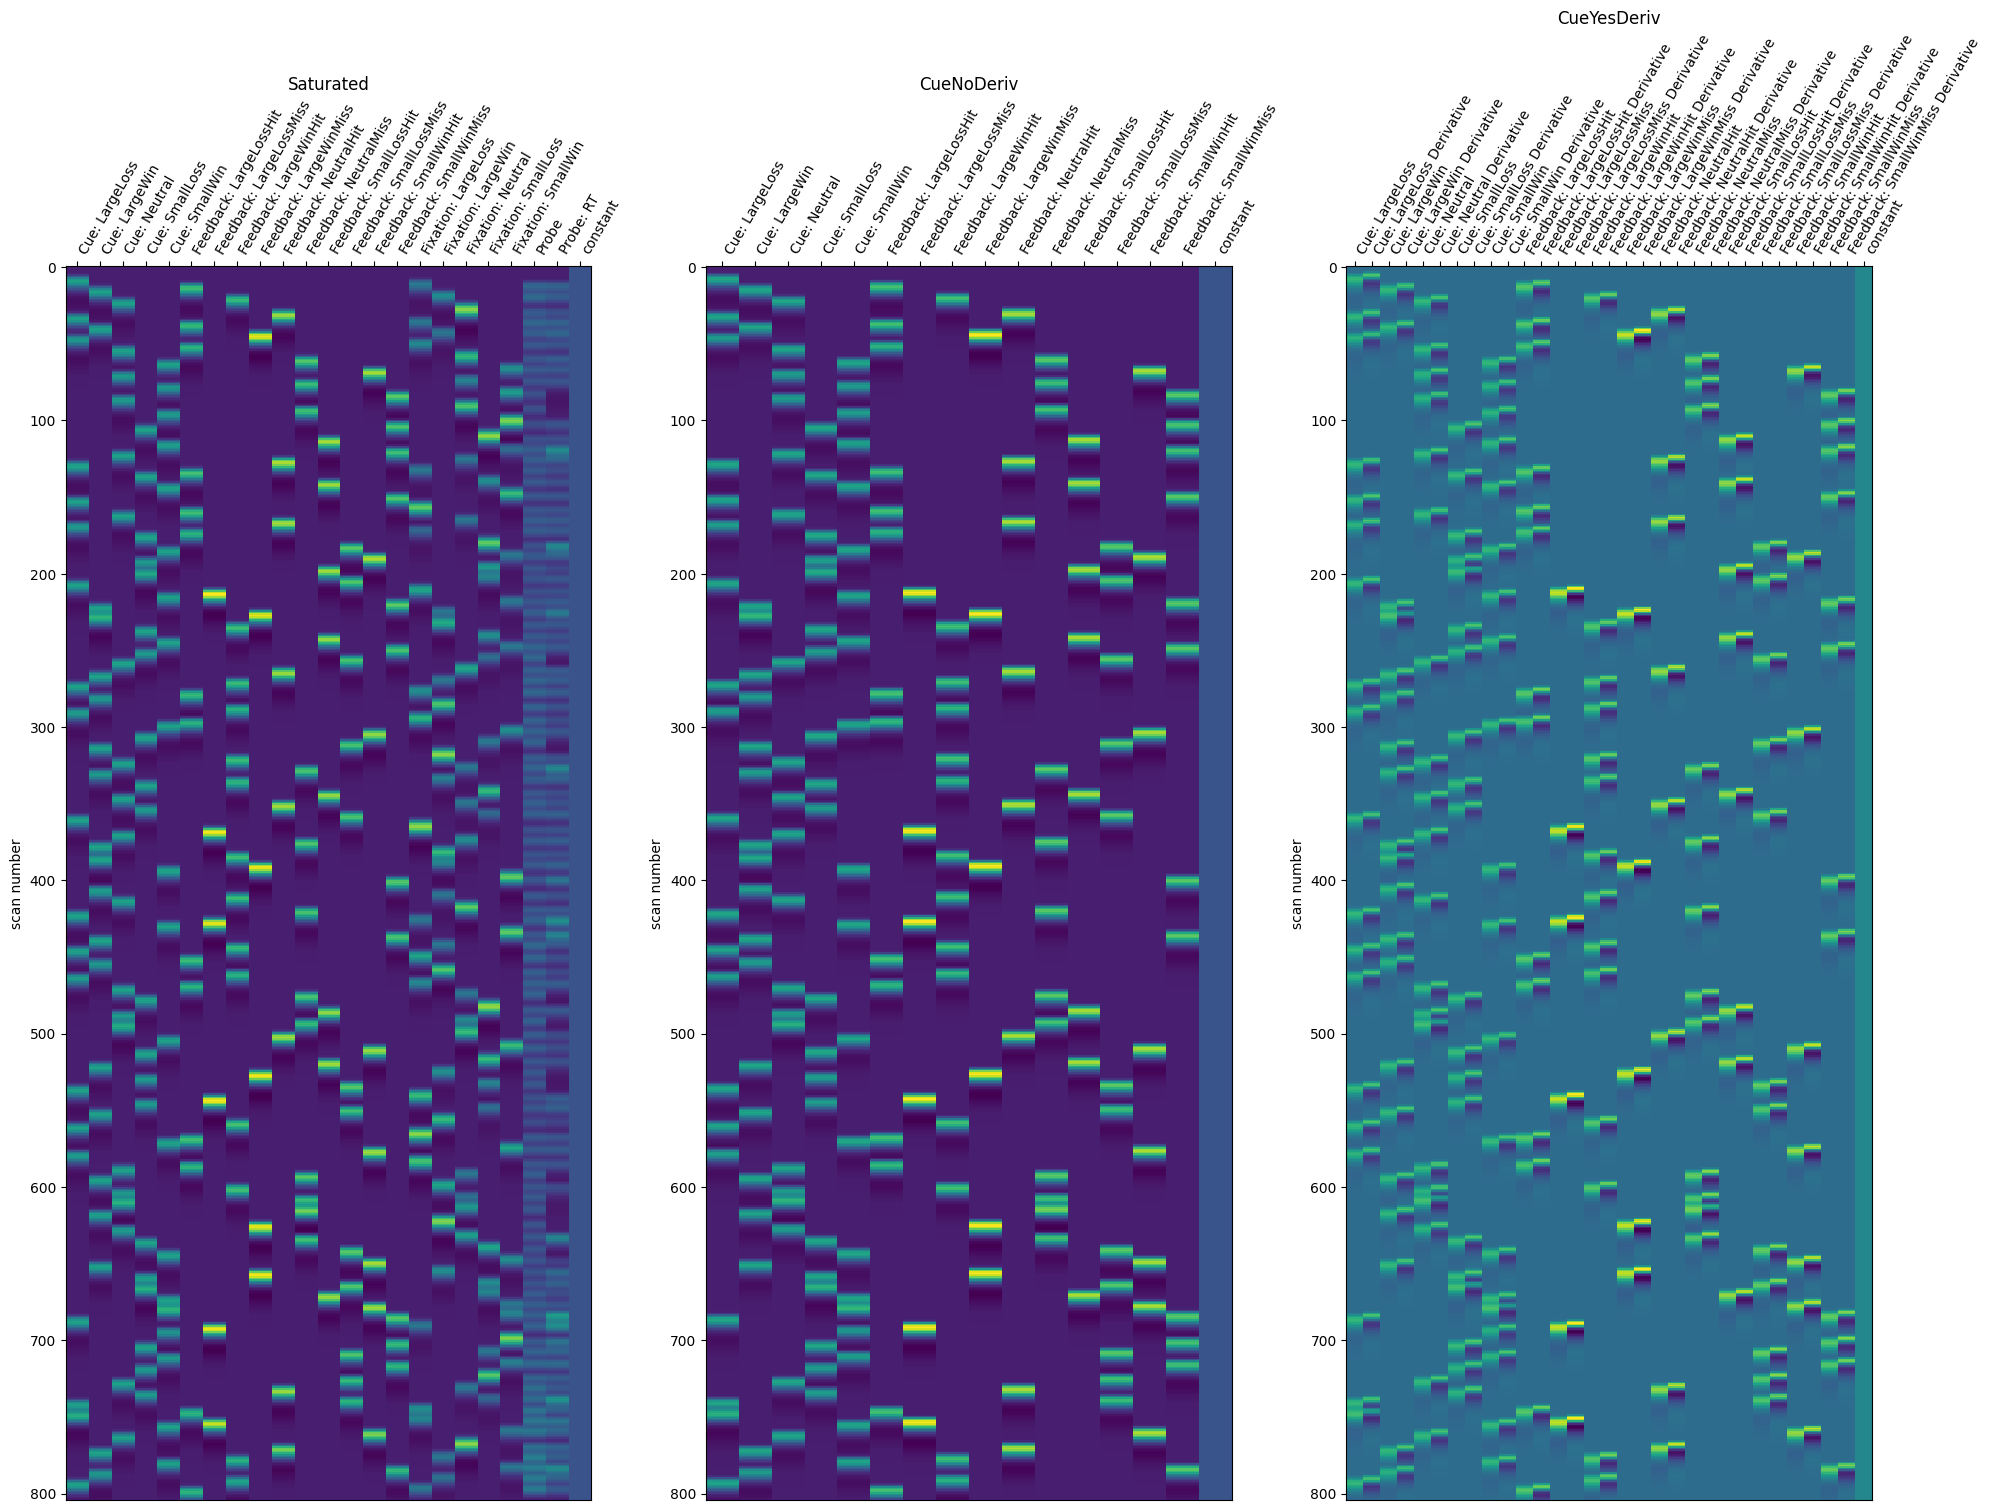

In [2]:
sub = 4
dataset = 'ABCD'
events = get_subdata_long(sub, dataset=dataset)
designs  = create_design_matrices(events, oversampling=50, tr=.8)

fig, ax = plt.subplots(1, 3, figsize=(20, 15))
ax_flat = ax.flatten()
for i, desname in enumerate(designs.keys()):
    plot_design_ordered_regressors(designs[desname], desname, ax=ax_flat[i])
plt.show()



In [3]:
contrast_strings, contrasts_matrices, c_pinv_xmats = create_contrasts(designs)
interesting_contrast_substr = ['CUE:', 'FB:']
for key, contrasts in contrast_strings.items():
    print(f'\n Contrasts for {key} model')
    for contrast_name, contrast_string in contrasts.items():
        if any(x in contrast_name for x in interesting_contrast_substr):
            print(f'{contrast_name}: {contrast_string}')


 Contrasts for Saturated model
CUE: W-base: .5 * Cue_LargeWin  + .5 * Cue_SmallWin
CUE: W-Neut: .5 * Cue_LargeWin  + .5 * Cue_SmallWin - 1 * Cue_Neutral
CUE: LW-Neut: 1 * Cue_LargeWin - 1 * Cue_Neutral
FB: WHit-NeutHit: .5 * Feedback_LargeWinHit + .5 * Feedback_SmallWinHit - 1 * Feedback_NeutralHit
FB: LWHit-LWMiss: 1 * Feedback_LargeWinHit - 1 * Feedback_LargeWinMiss

 Contrasts for CueNoDeriv model
CUE: W-base: .5 * Cue_LargeWin  + .5 * Cue_SmallWin
CUE: W-Neut: .5 * Cue_LargeWin  + .5 * Cue_SmallWin - 1 * Cue_Neutral
CUE: LW-Neut: 1 * Cue_LargeWin - 1 * Cue_Neutral
FB: WHit-NeutHit: .5 * Feedback_LargeWinHit + .5 * Feedback_SmallWinHit - 1 * Feedback_NeutralHit
FB: LWHit-LWMiss: 1 * Feedback_LargeWinHit - 1 * Feedback_LargeWinMiss

 Contrasts for CueYesDeriv model
CUE: W-base: .5 * Cue_LargeWin  + .5 * Cue_SmallWin
CUE: W-Neut: .5 * Cue_LargeWin  + .5 * Cue_SmallWin - 1 * Cue_Neutral
CUE: LW-Neut: 1 * Cue_LargeWin - 1 * Cue_Neutral
FB: WHit-NeutHit: .5 * Feedback_LargeWinHit + .5 *

In [4]:
beta_dicts = get_beta_dicts(dataset='ABCD')

dataset='ABCD'
beta_sub_sd = 1
noise_sd = 1
nsims = 1000
results = {}

for beta_dict in beta_dicts:
    print(beta_dict)
    figure_label = make_analysis_label(beta_dict)
    results[figure_label], _, model_example = sim_group_models_parallel(
        beta_dict, 
        noise_sd, 
        beta_sub_sd, 
        nsims=nsims, 
        oversampling=50, 
        tr=.8,
        dataset=dataset
        )


{}
{'Cue: LargeWin': 0.4, 'Cue: SmallWin': 0.4}
{'Fixation: LargeWin': 0.5, 'Fixation: SmallWin': 0.5}
{'Cue: LargeWin': 0.25, 'Cue: SmallWin': 0.25, 'Fixation: LargeWin': 0.25, 'Fixation: SmallWin': 0.25}
{'Probe: RT': 5}
{'Feedback: LargeWinHit': 0.4, 'Feedback: SmallWinHit': 0.4}
{'Feedback: LargeWinHit': 0.2, 'Feedback: LargeWinMiss': -0.2}


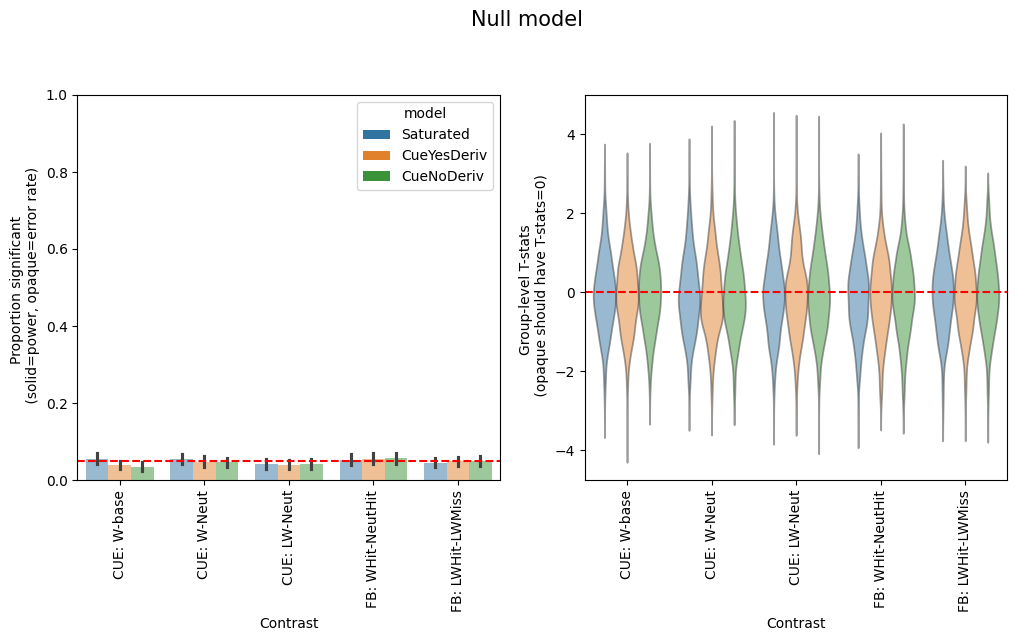

In [5]:
plot_dict_of_results({'Null model': results['Null model']}, contrasts=True)

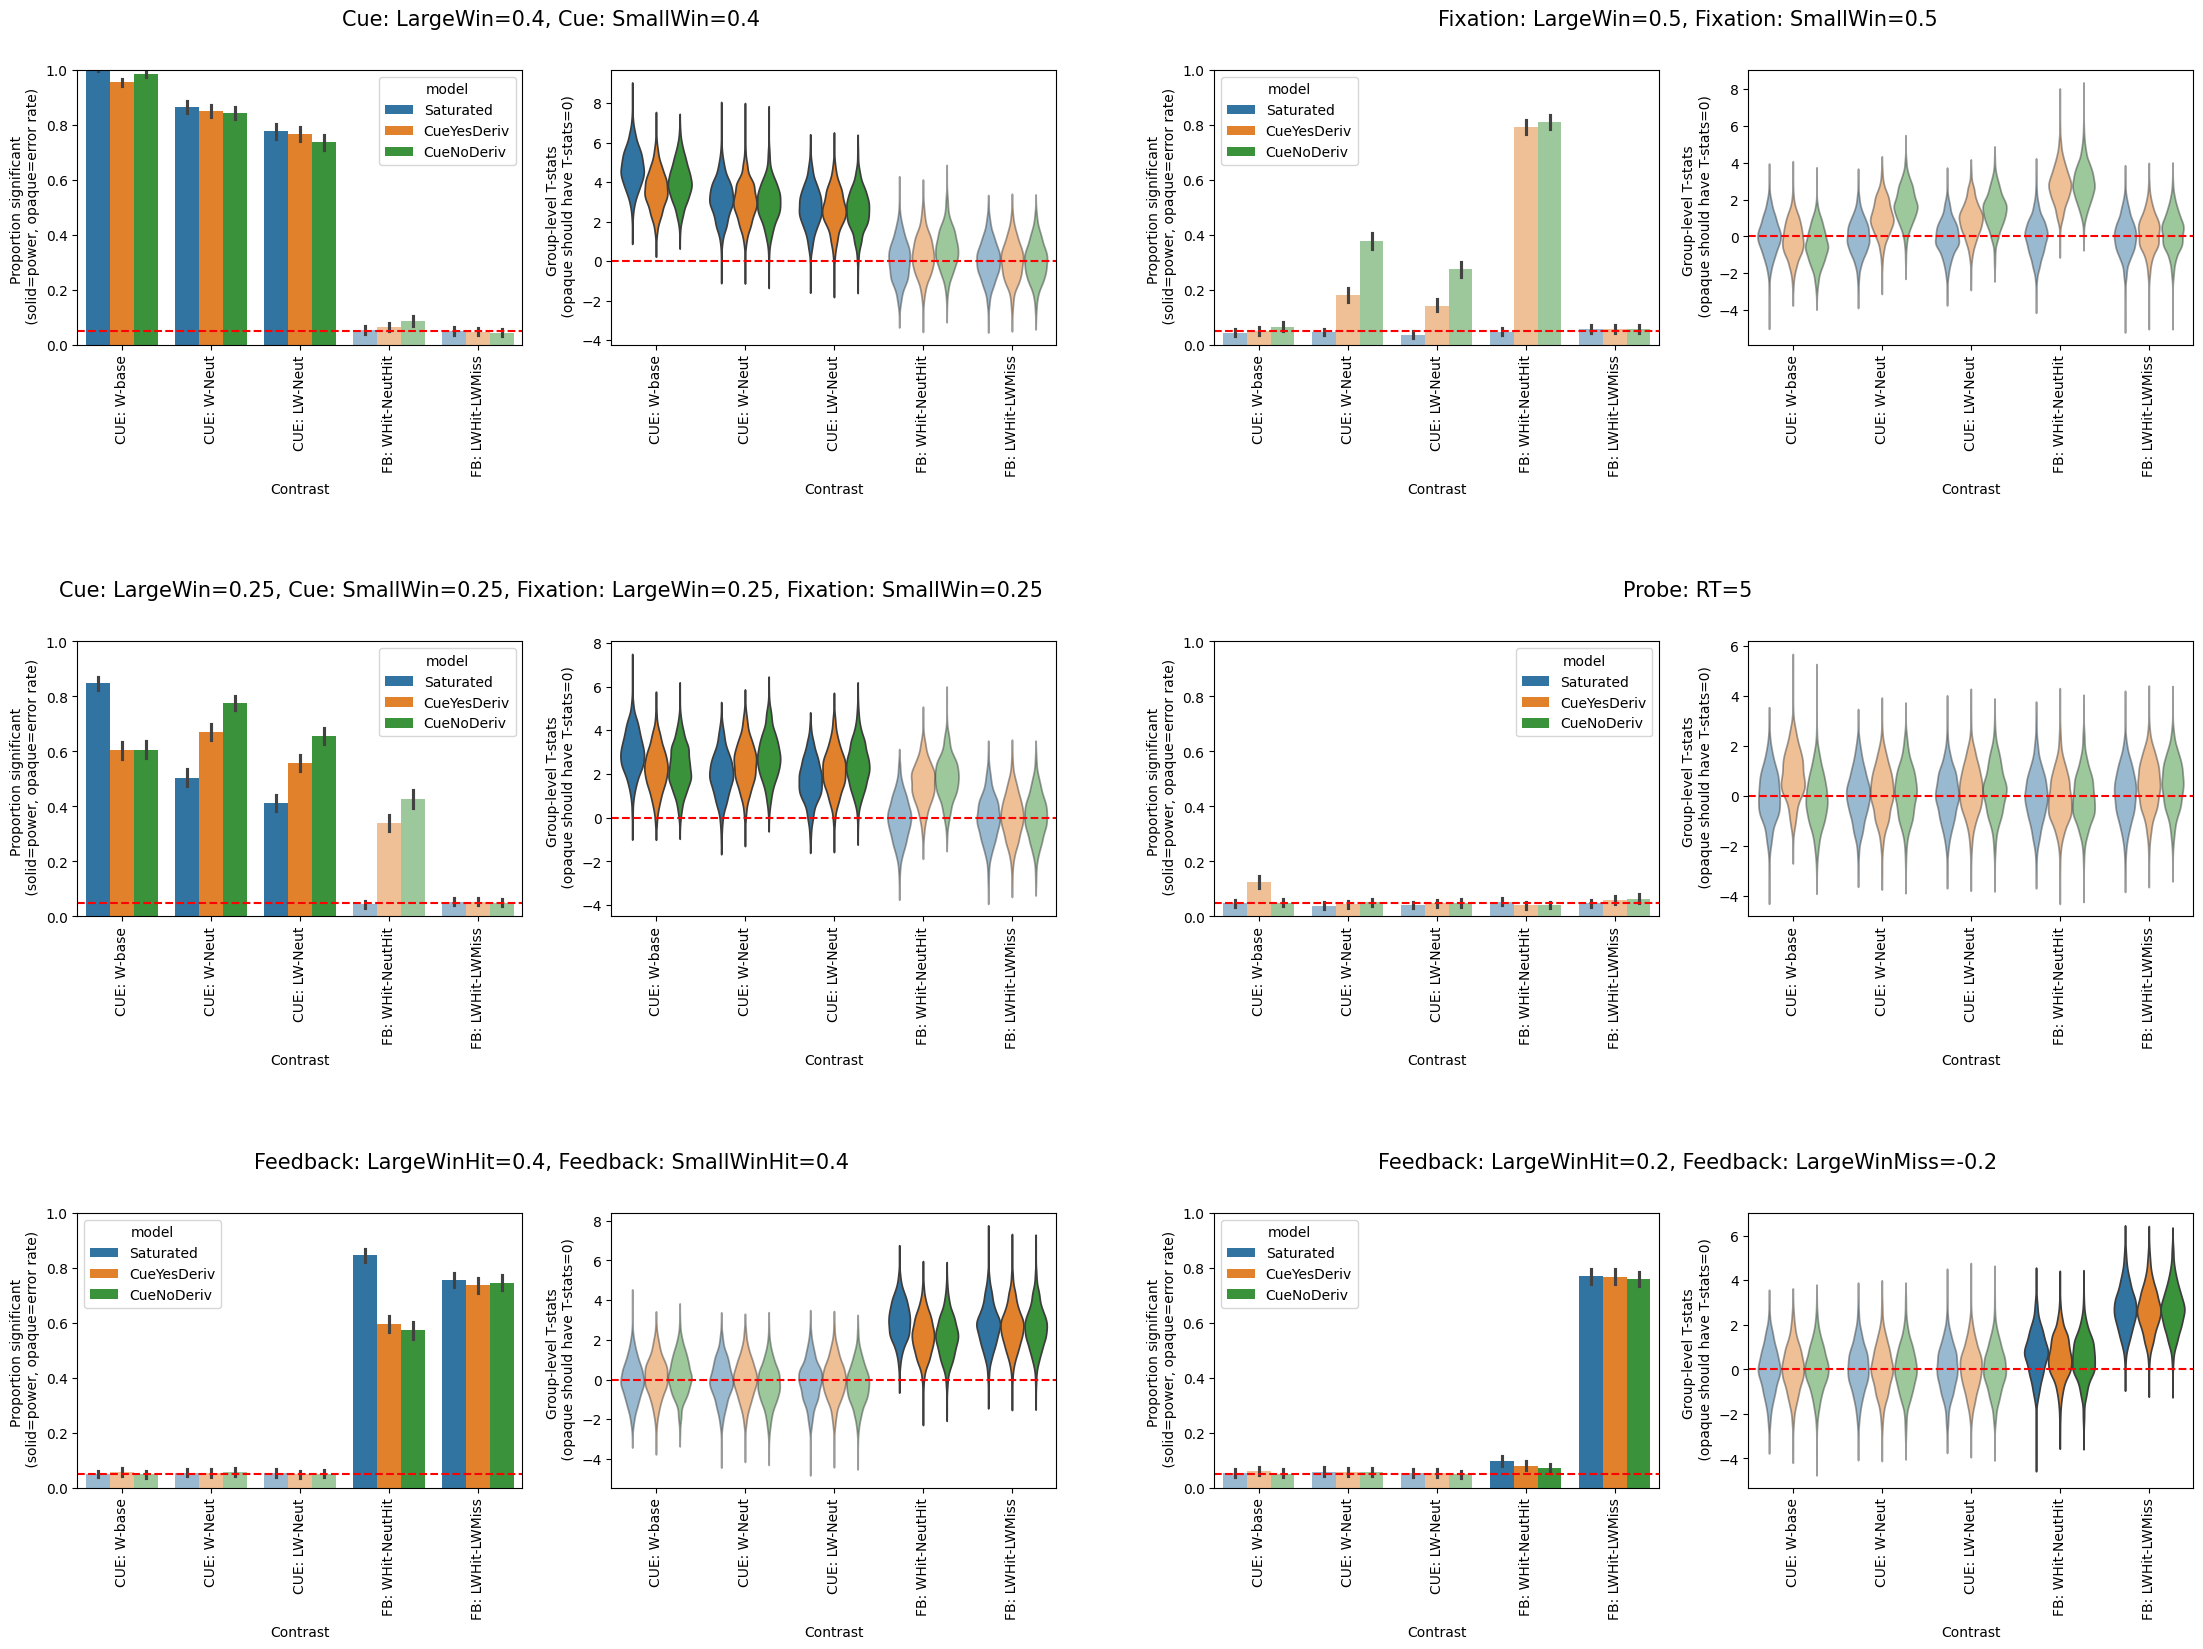

In [6]:
results_plot = results.copy()
results_plot.pop('Null model')
plot_dict_of_results(results_plot, contrasts=True)

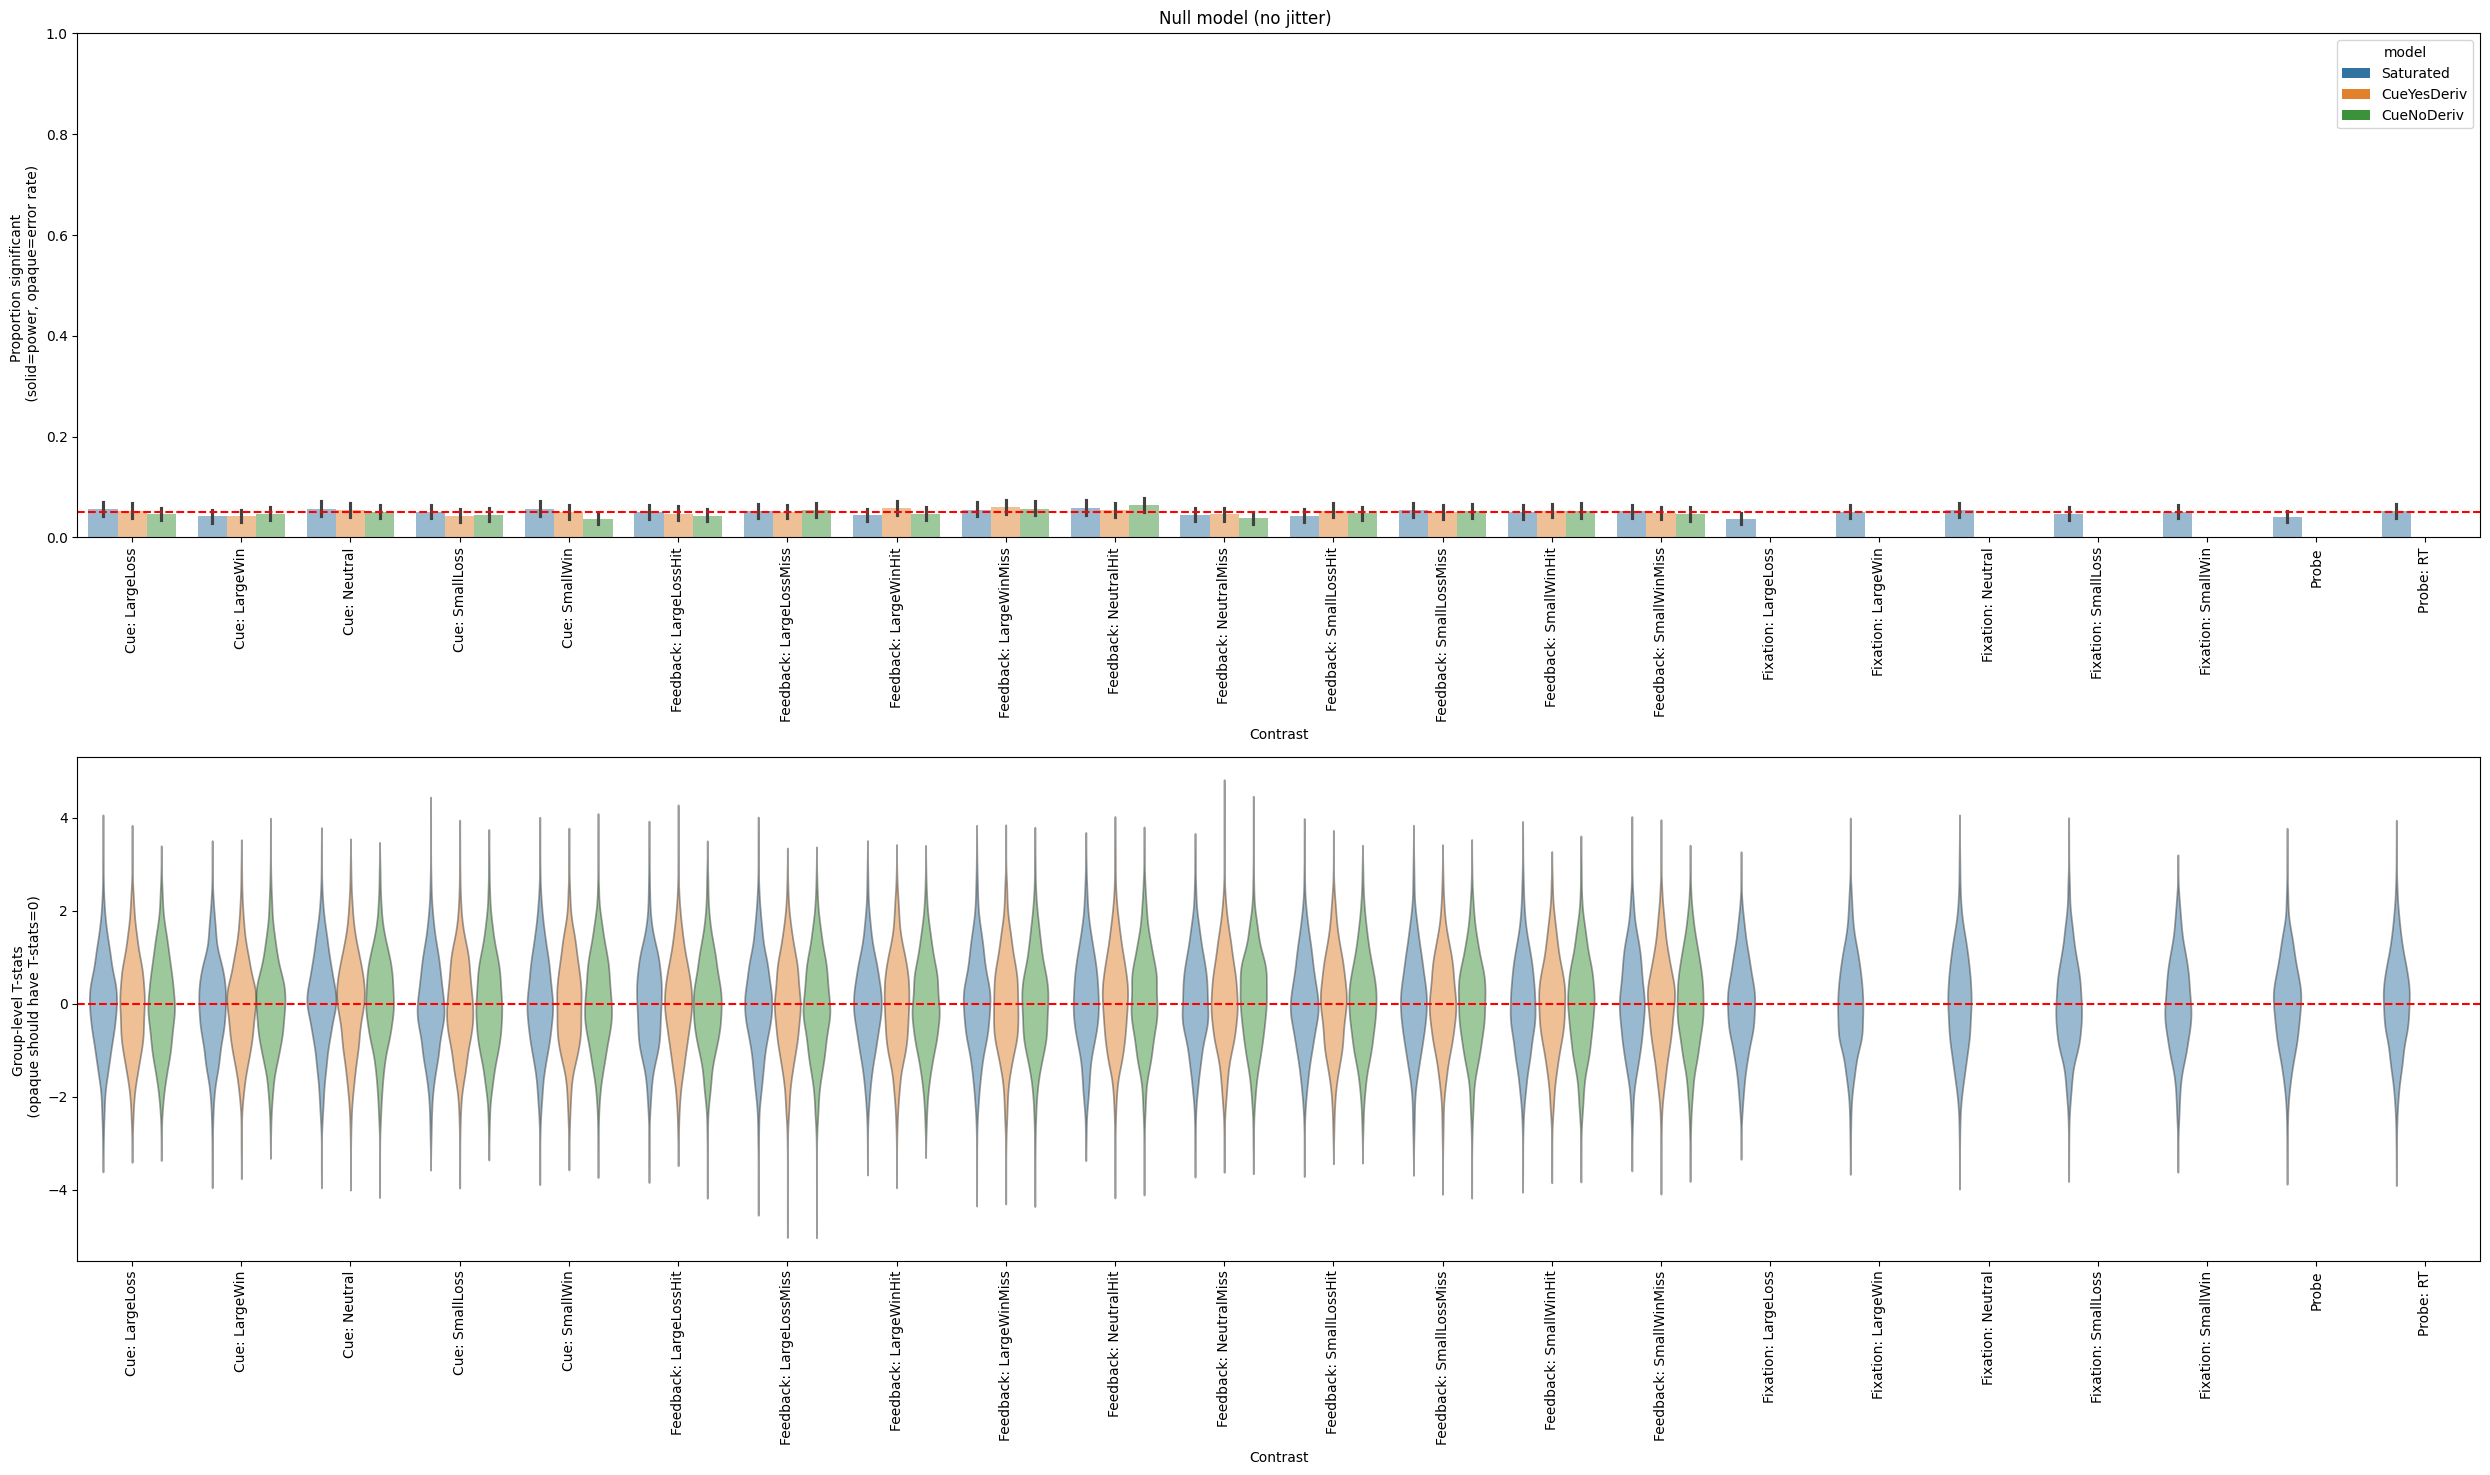

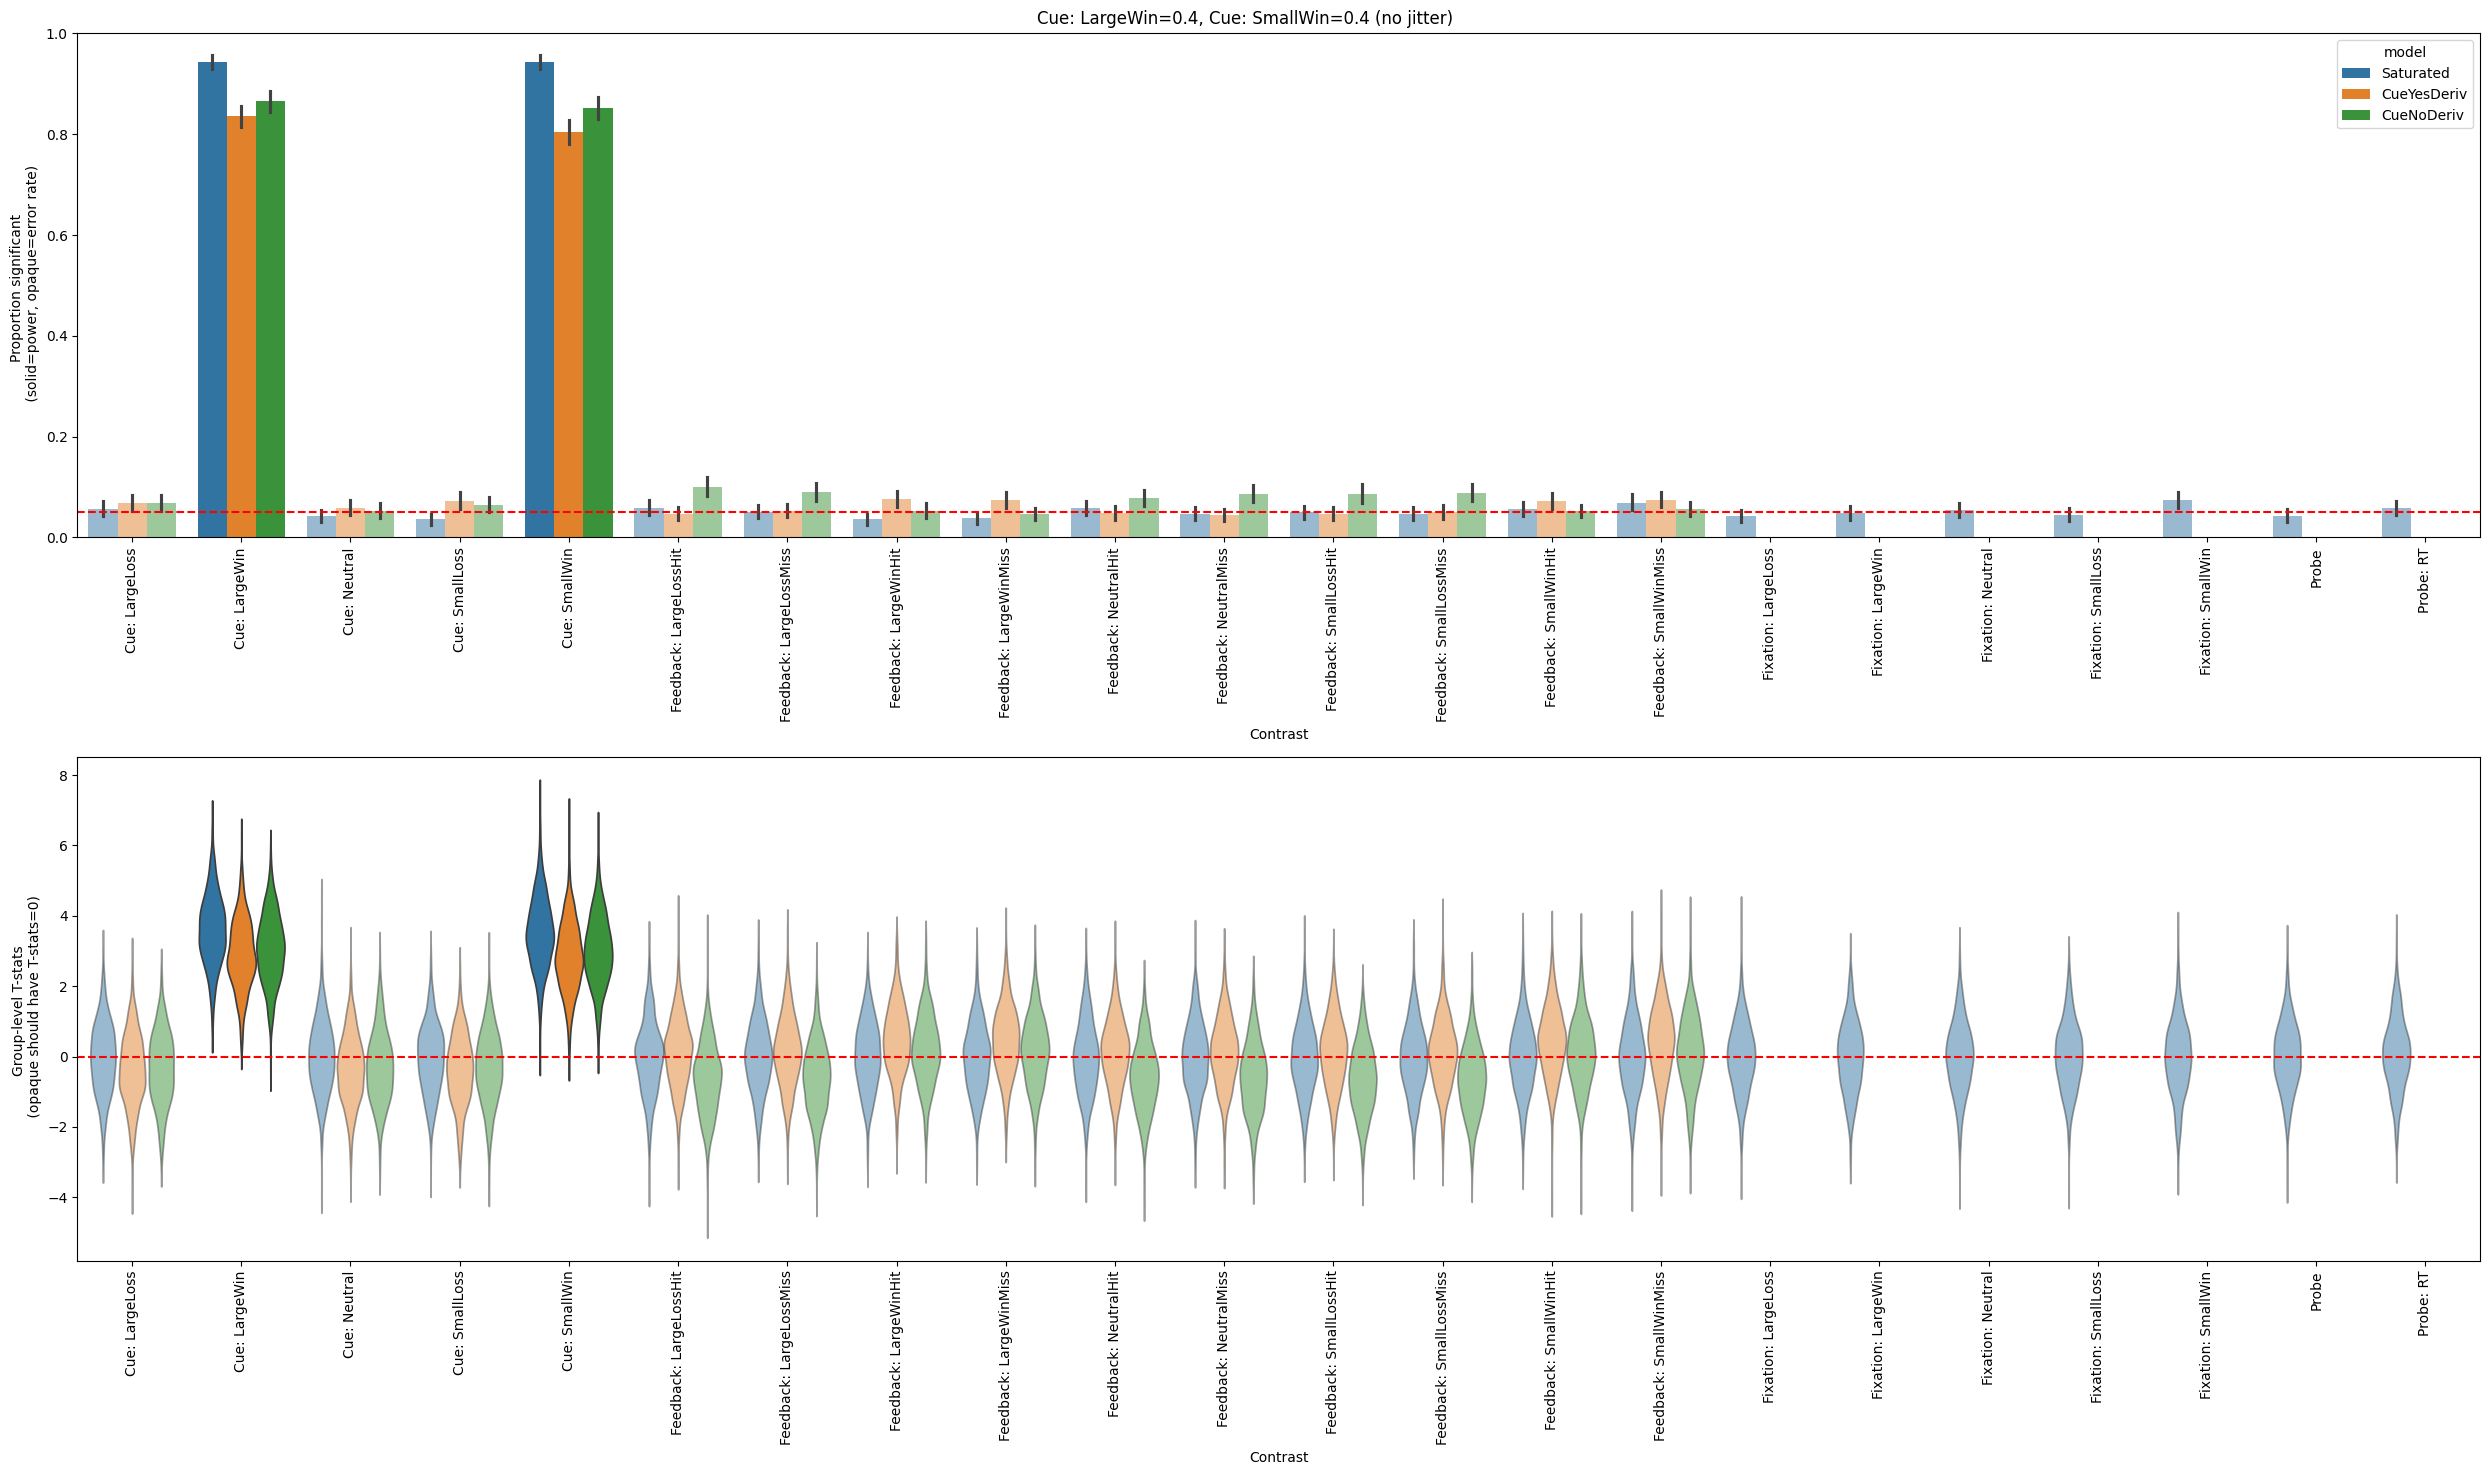

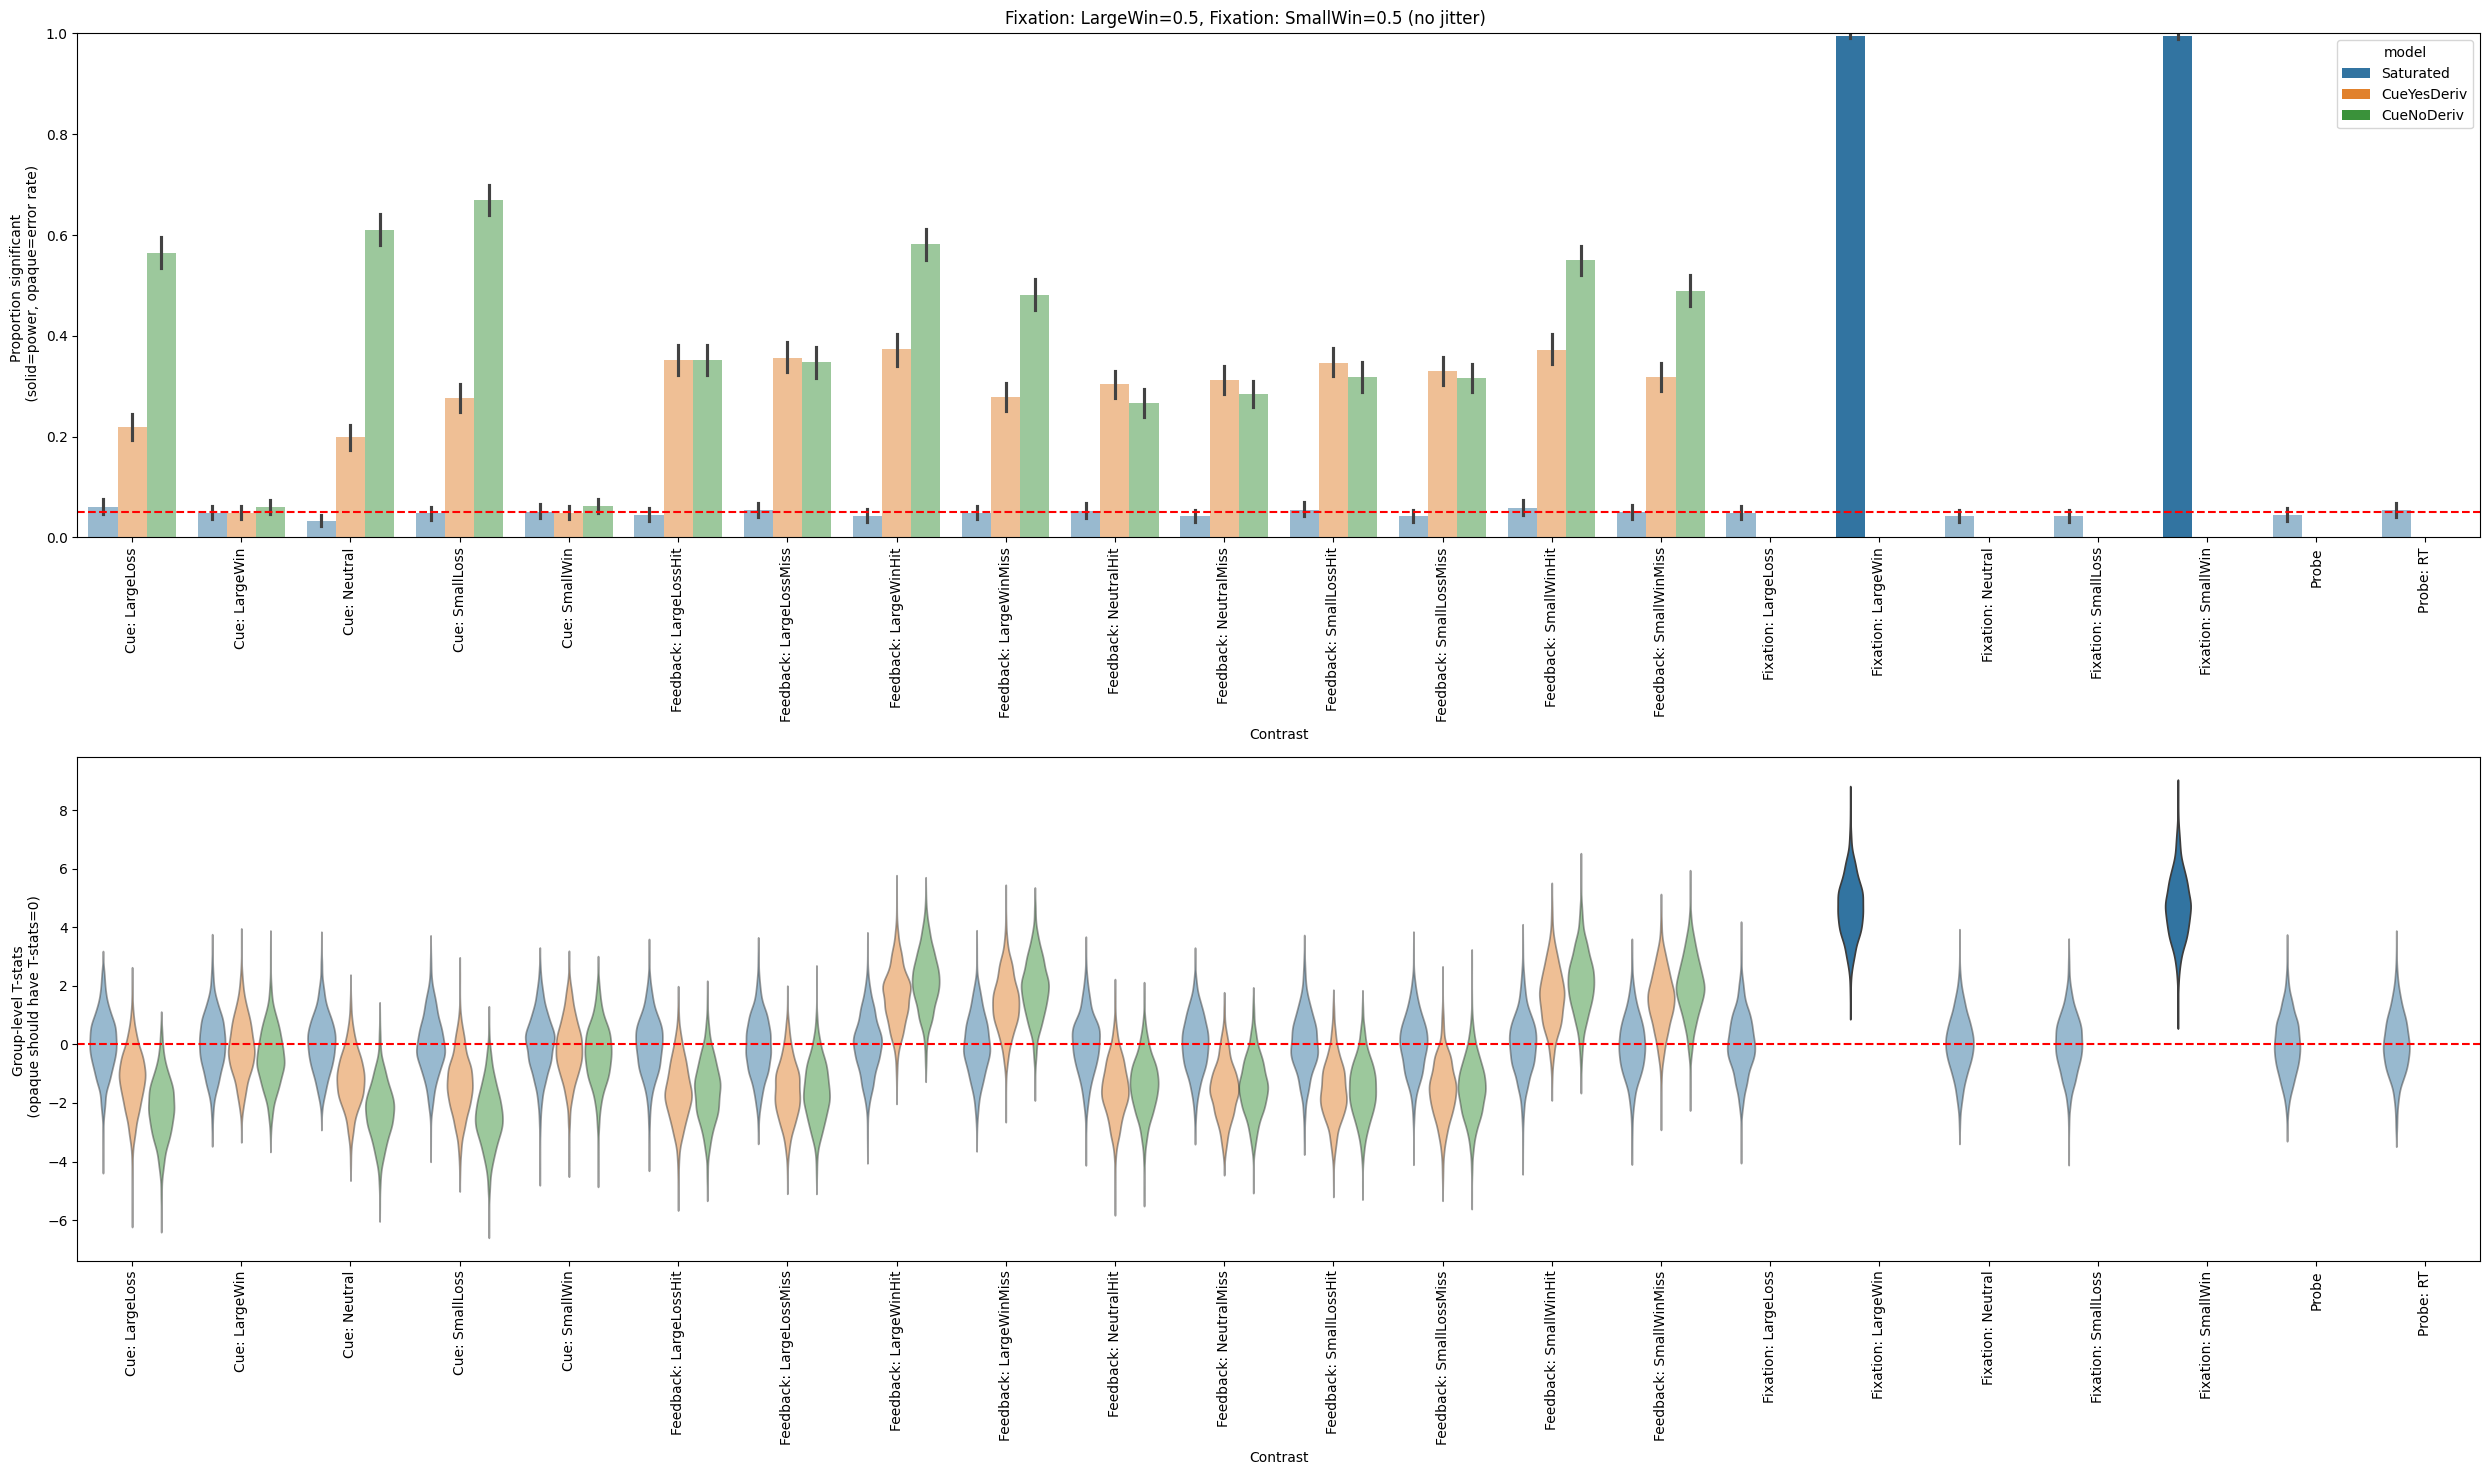

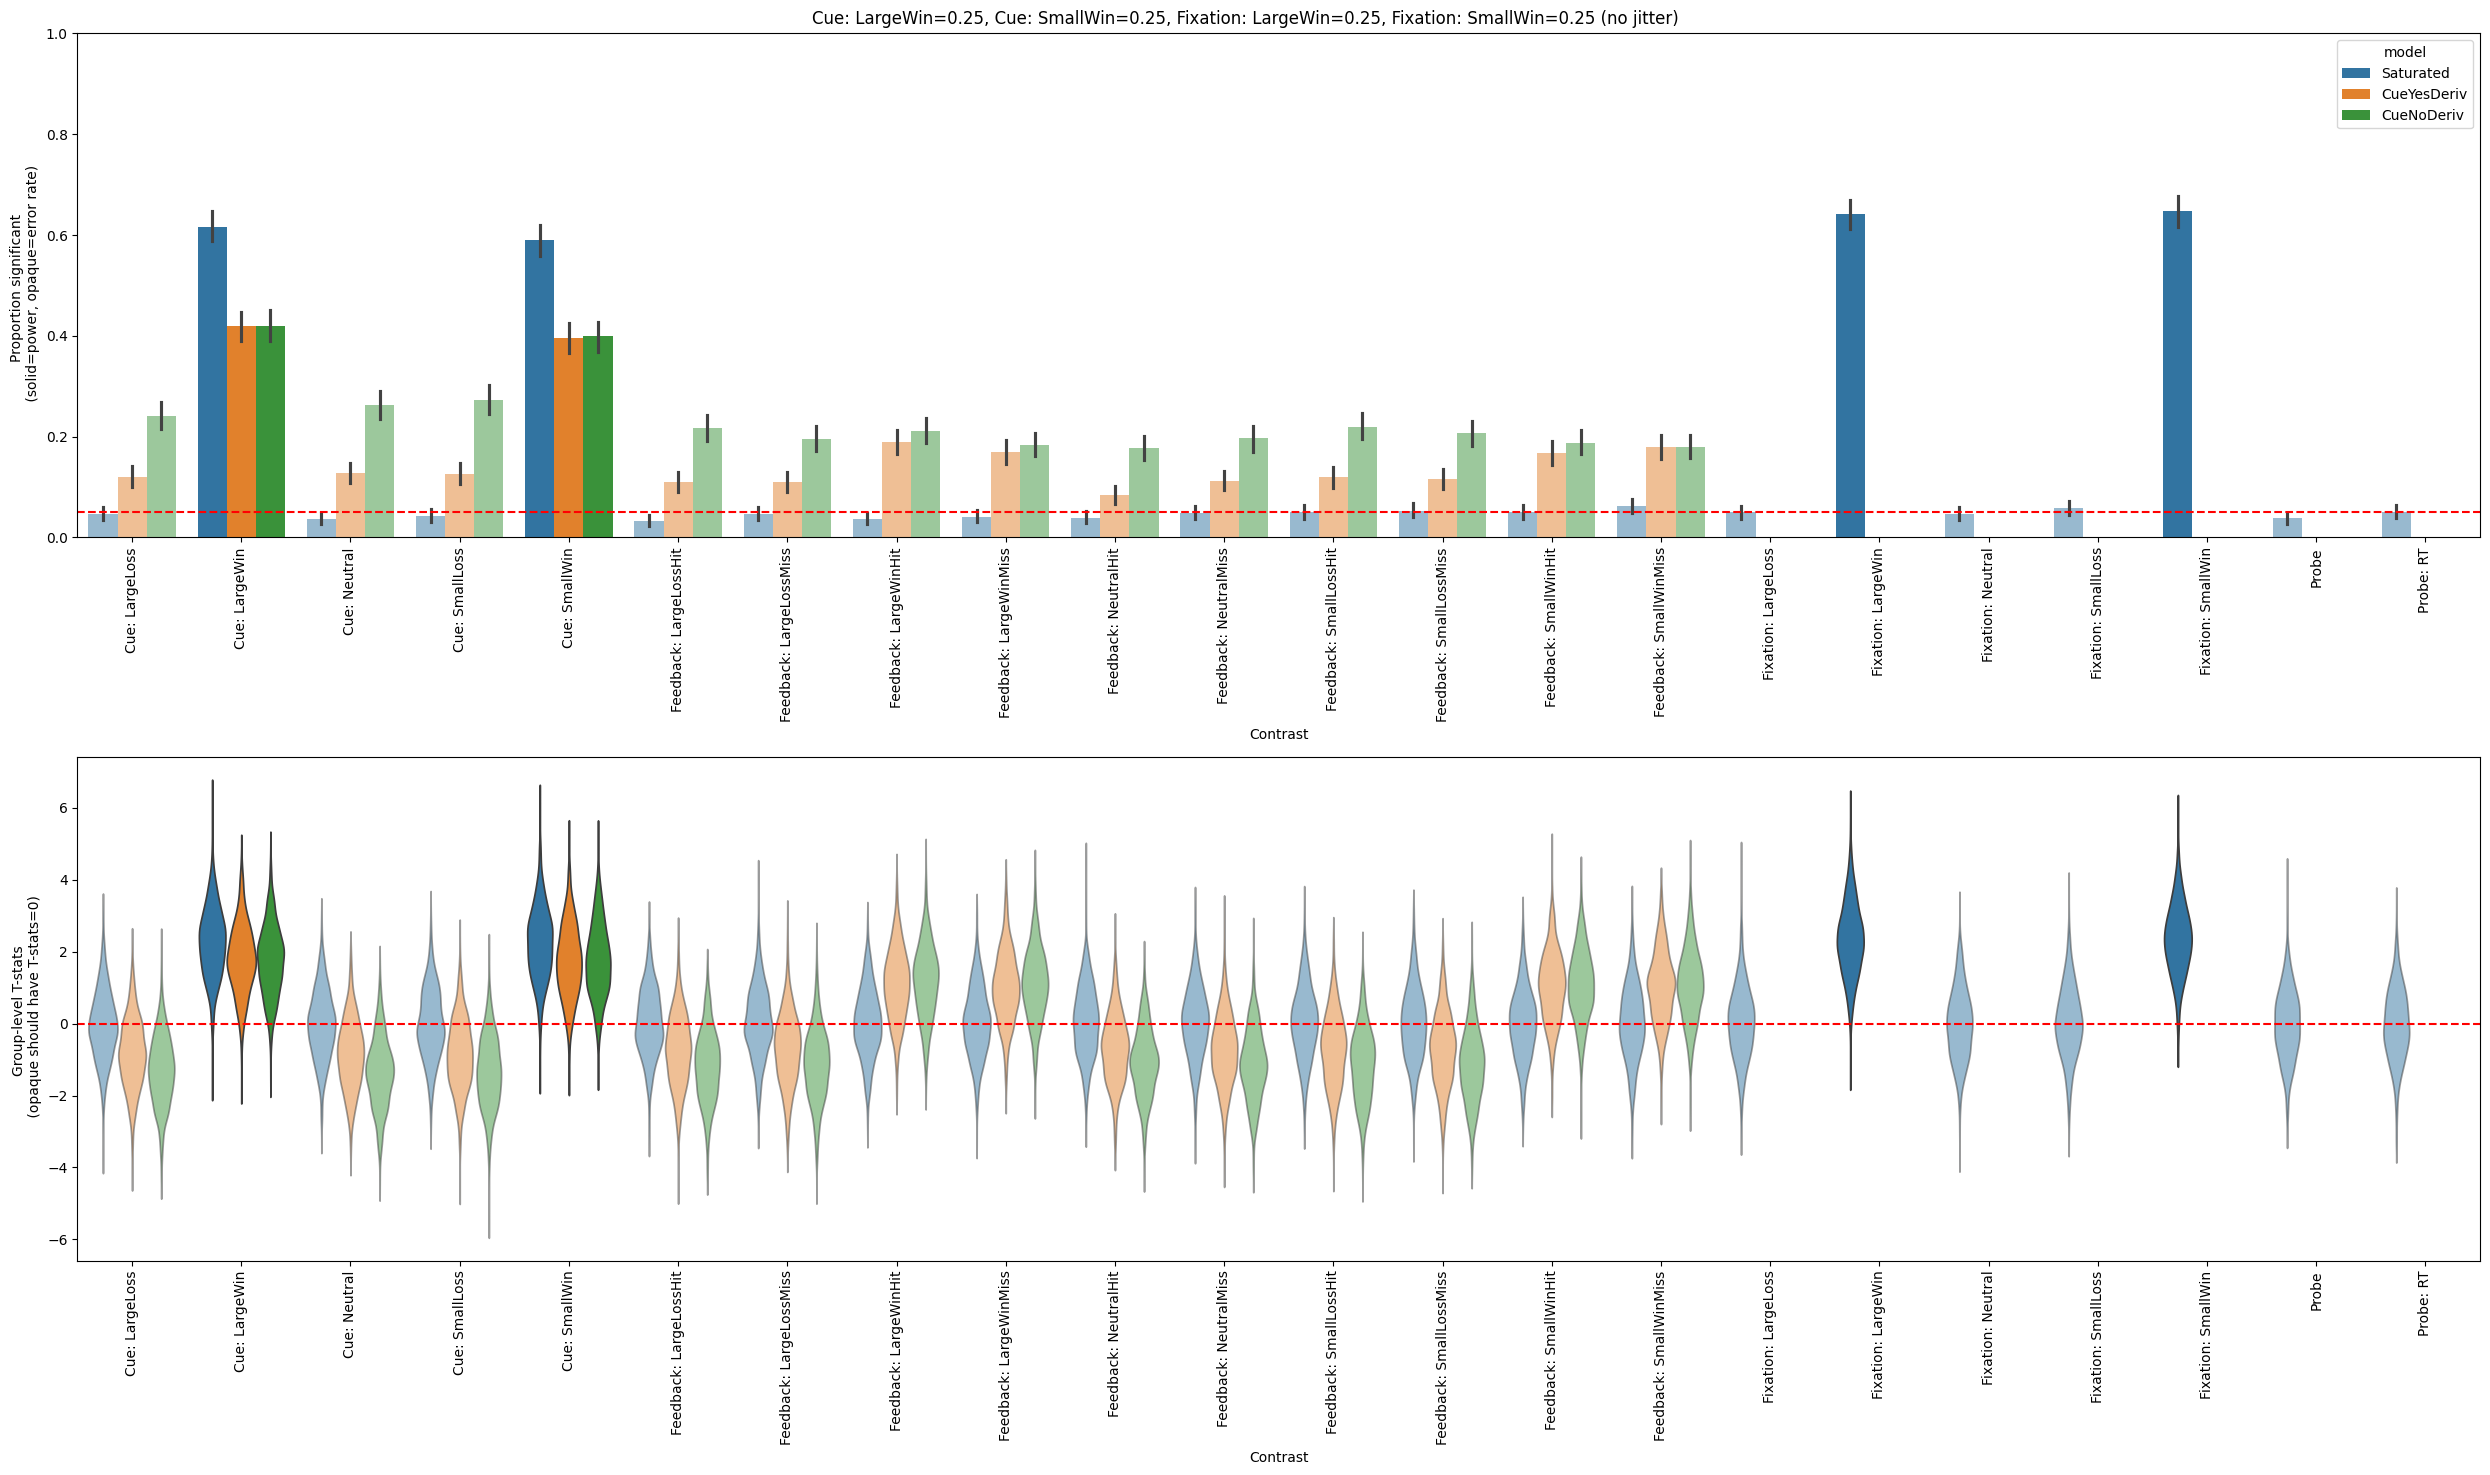

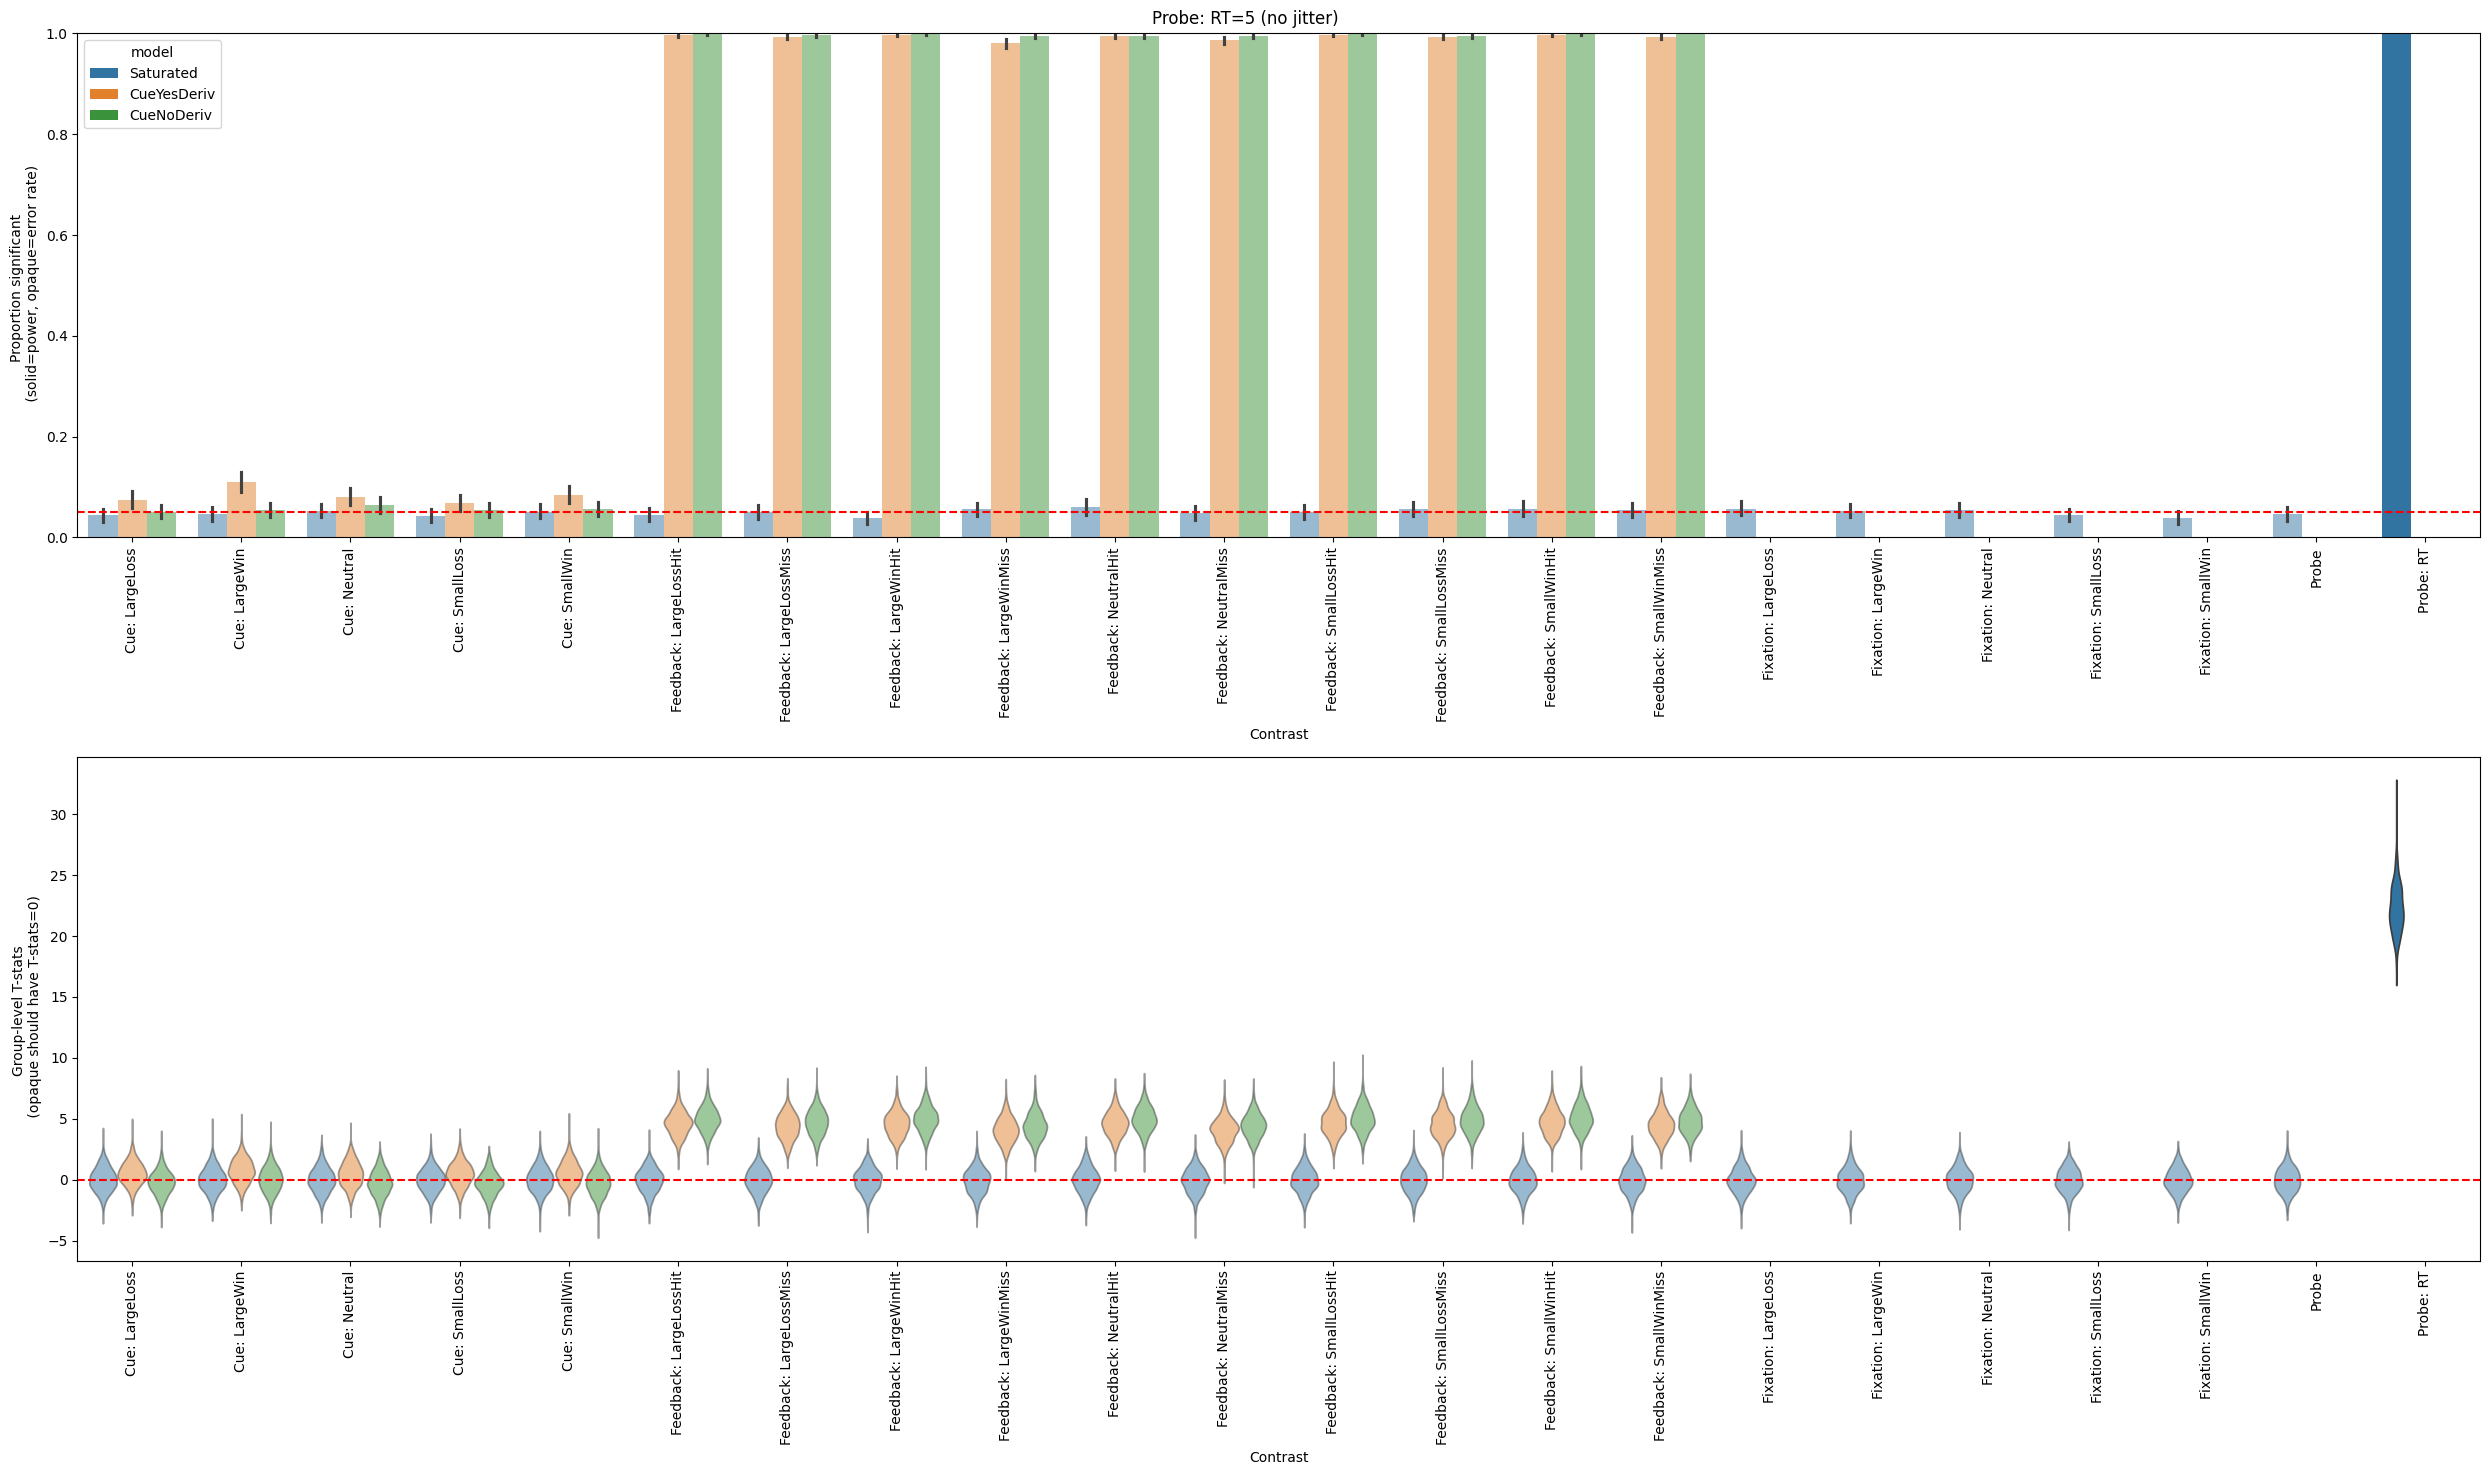

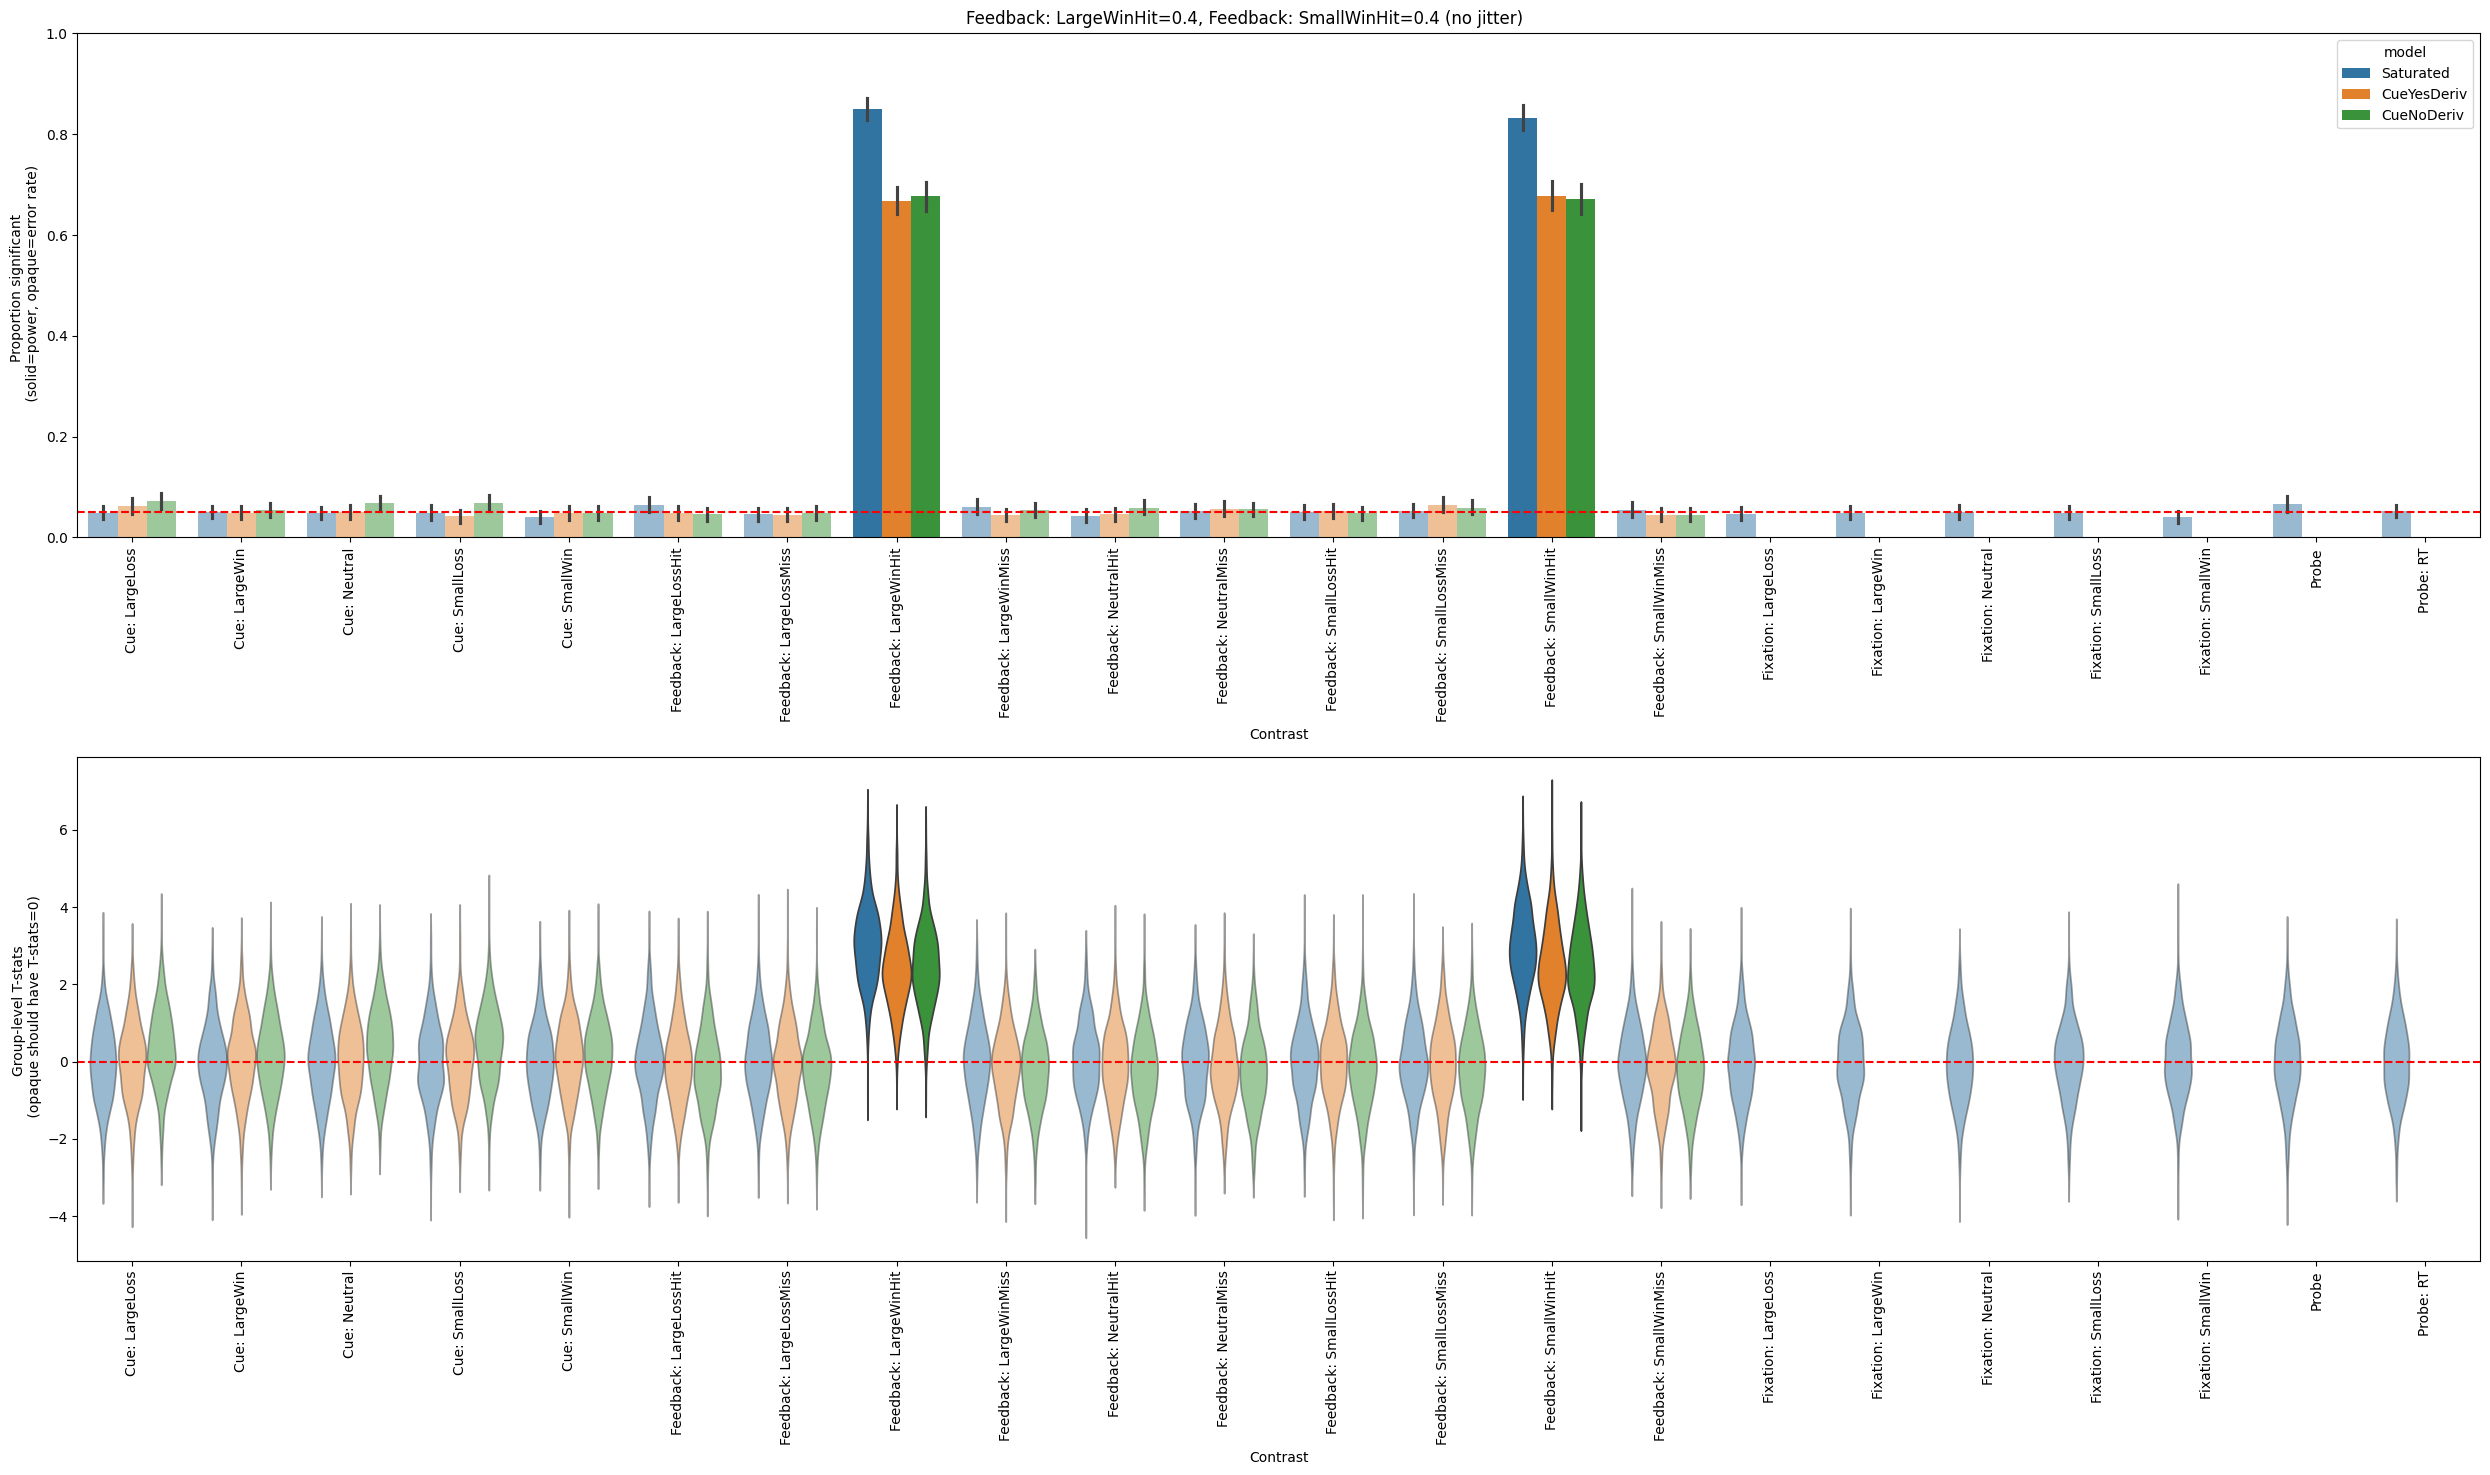

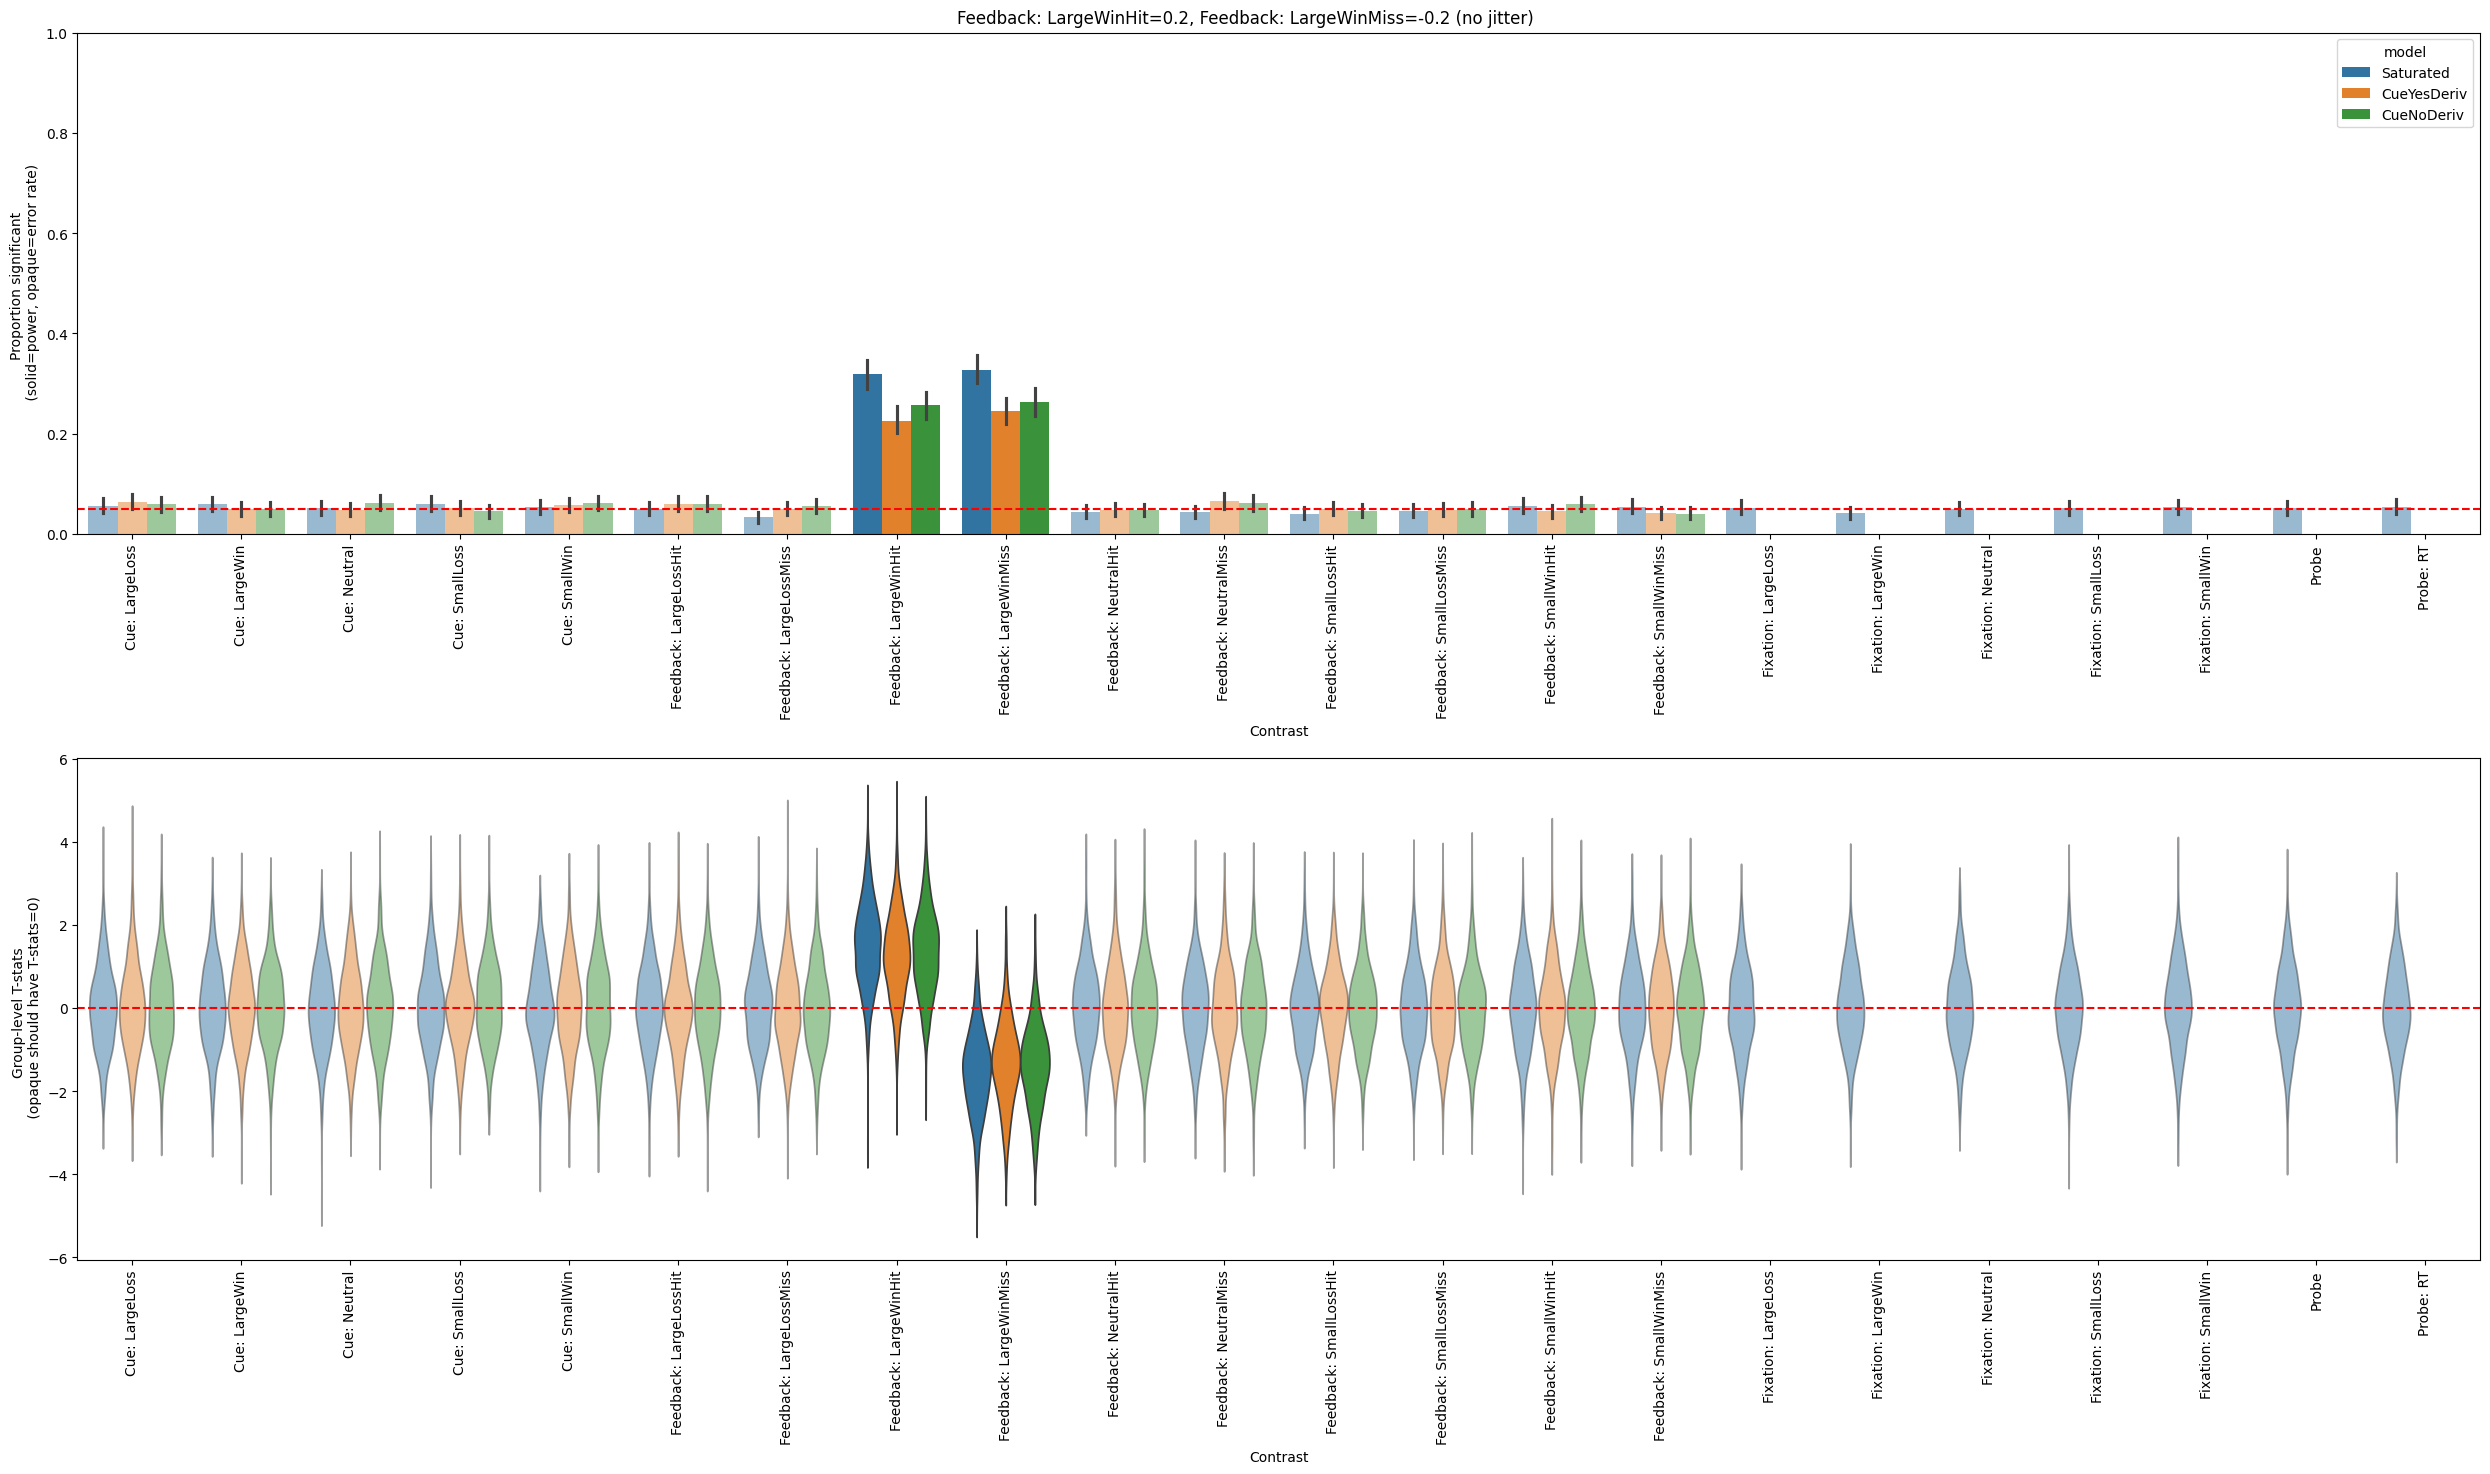

In [7]:
for name, result in results.items():
    result_loop = result[~result['contrast'].str.contains('-|Derivative')].copy()
    plot_results(result_loop, 
        f'{name} (no jitter)', stacked=True)

In [41]:
def plot_bias(results):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap.set_bad("lightgrey")

    num_plots = len(results.keys())
    f, axs = plt.subplots(
        len(results.keys()),
        1,  # gridspec_kw={'hspace': 0.5},
        figsize=(20, 10),
        sharex=True,
    )
    cbar_ax = f.add_axes([0.91, 0.4, 0.03, 0.5])
    f.suptitle("Bias \nAverage of group T-statistics across simulations \nBias occurs when values are nonzero", fontsize=16)
    for idx, (setting, data) in enumerate(results.items()):
        data = data.copy()
        data.loc[data["plot_alpha_val_power_error"] == 1, "tval"] = np.nan
        setting = setting.replace(", ", "\n")
        dat_plot = (
            data.groupby(["contrast", "model"])[["tval"]]
            .mean()
            .reset_index()
            .pivot(index="contrast", columns="model", values="tval")
            .transpose()
        )
        # dat_plot = dat_plot[dat_plot.columns.drop(list(dat_plot.filter(regex="-")))]        
        dat_plot = dat_plot[
            dat_plot.columns.drop(list(dat_plot.filter(regex="Derivative")))
        ]
        #dat_plot = dat_plot[sorted(dat_plot.columns)]
        dat_plot = dat_plot[sorted(dat_plot.columns, key=lambda x: ('-' in x, x))]
        g = sns.heatmap(
            dat_plot,
            vmin=-0.5,
            vmax=1,
            center=0,
            cbar=idx == 0,
            cmap=cmap,
            ax=axs[idx],
            cbar_ax=None if idx else cbar_ax,
            annot=True,
            fmt=".2f",
        )
        if idx < num_plots - 1:
            axs[idx].set_xlabel("")
        axs[idx].set_ylabel(setting, rotation=0, labelpad=200, loc="bottom")
    plt.show()

In [39]:
def plot_error_grid(results):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap.set_bad("lightgrey")

    num_plots = len(results.keys())
    f, axs = plt.subplots(
        len(results.keys()),
        1,  # gridspec_kw={'hspace': 0.5},
        figsize=(20, 10),
        sharex=True,
    )
    cbar_ax = f.add_axes([0.91, 0.4, 0.03, 0.5])
    f.suptitle("Type I error rates", fontsize=16)
    for idx, (setting, data) in enumerate(results.items()):
        data = data.copy()
        data['sigp'] = data['sigp'].astype(float)
        data.loc[data["plot_alpha_val_power_error"] == 1, "sigp"] = pd.NA
        setting = setting.replace(", ", "\n")
        dat_plot = (
            data.groupby(["contrast", "model"])[["sigp"]]
            .mean()
            .reset_index()
            .pivot(index="contrast", columns="model", values="sigp")
            .transpose()
        )
        # dat_plot = dat_plot[dat_plot.columns.drop(list(dat_plot.filter(regex="-")))]        
        dat_plot = dat_plot[
            dat_plot.columns.drop(list(dat_plot.filter(regex="Derivative")))
        ]
        #dat_plot = dat_plot[sorted(dat_plot.columns)]
        dat_plot = dat_plot[sorted(dat_plot.columns, key=lambda x: ('-' in x, x))]
        g = sns.heatmap(
            dat_plot,
            vmin=0,
            vmax=1,
            center=0.05,
            cbar=idx == 0,
            cmap=cmap,
            ax=axs[idx],
            cbar_ax=None if idx else cbar_ax,
            annot=True,
            fmt=".2f",
        )
        if idx < num_plots - 1:
            axs[idx].set_xlabel("")
        axs[idx].set_ylabel(setting, rotation=0, labelpad=200, loc="bottom")
    plt.show()

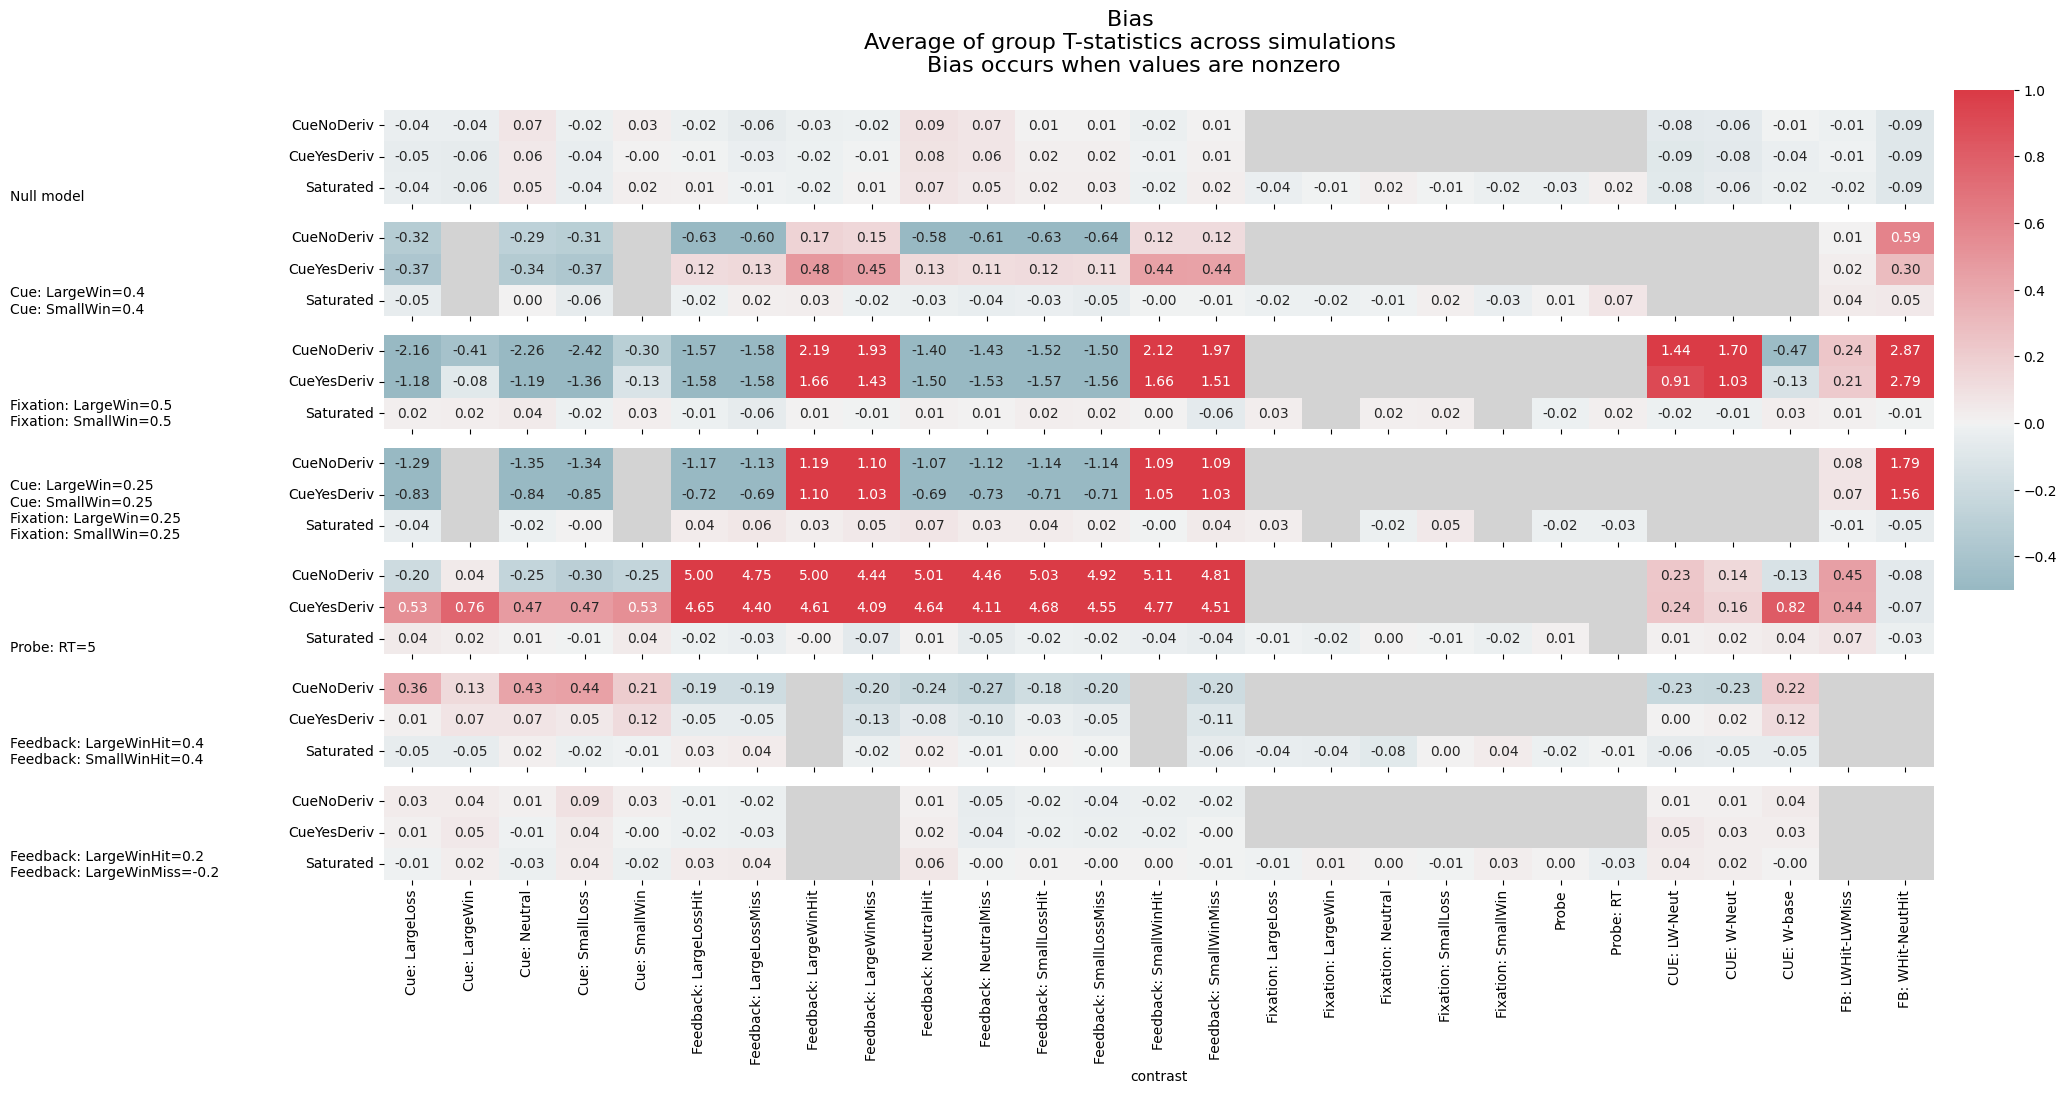

In [42]:
plot_bias(results)

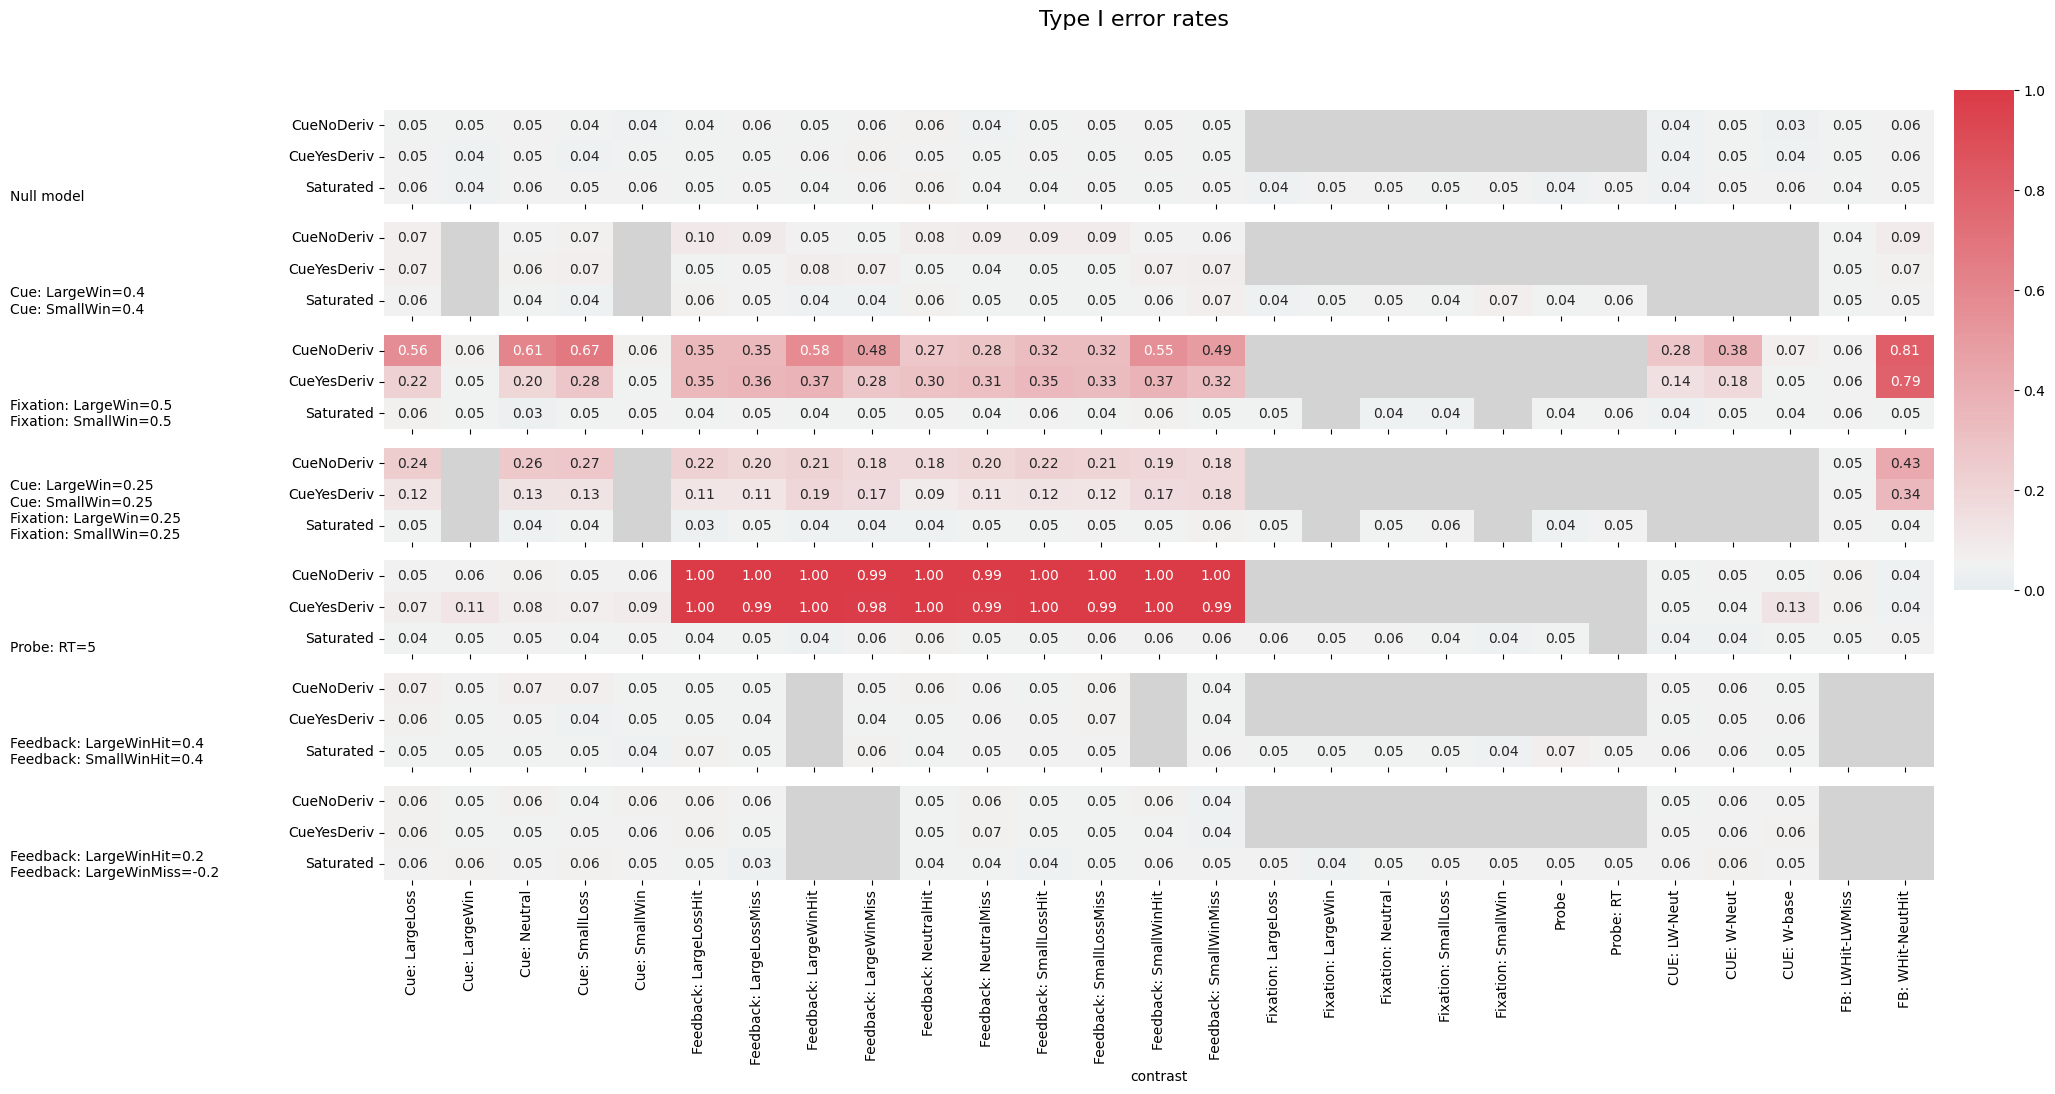

In [40]:
plot_error_grid(results)

## What if we add jitter?

In [9]:
dataset='ABCD'
beta_sub_sd = 1
noise_sd = 1
nsims = 1000

results_jitter = {}

for beta_dict in beta_dicts:
    print(beta_dict)
    figure_label = make_analysis_label(beta_dict)
    results_jitter[figure_label], _, desmat_example_jitter = sim_group_models_parallel(beta_dict, noise_sd, 
                                                                beta_sub_sd, nsims=nsims, oversampling=5, tr=1,
                                                                jitter=True, jitter_iti_min=2, jitter_iti_max=5,
                                                                dataset=dataset)

{}
{'Cue: LargeWin': 0.4, 'Cue: SmallWin': 0.4}
{'Fixation: LargeWin': 0.5, 'Fixation: SmallWin': 0.5}
{'Cue: LargeWin': 0.25, 'Cue: SmallWin': 0.25, 'Fixation: LargeWin': 0.25, 'Fixation: SmallWin': 0.25}
{'Probe: RT': 5}
{'Feedback: LargeWinHit': 0.4, 'Feedback: SmallWinHit': 0.4}
{'Feedback: LargeWinHit': 0.2, 'Feedback: LargeWinMiss': -0.2}


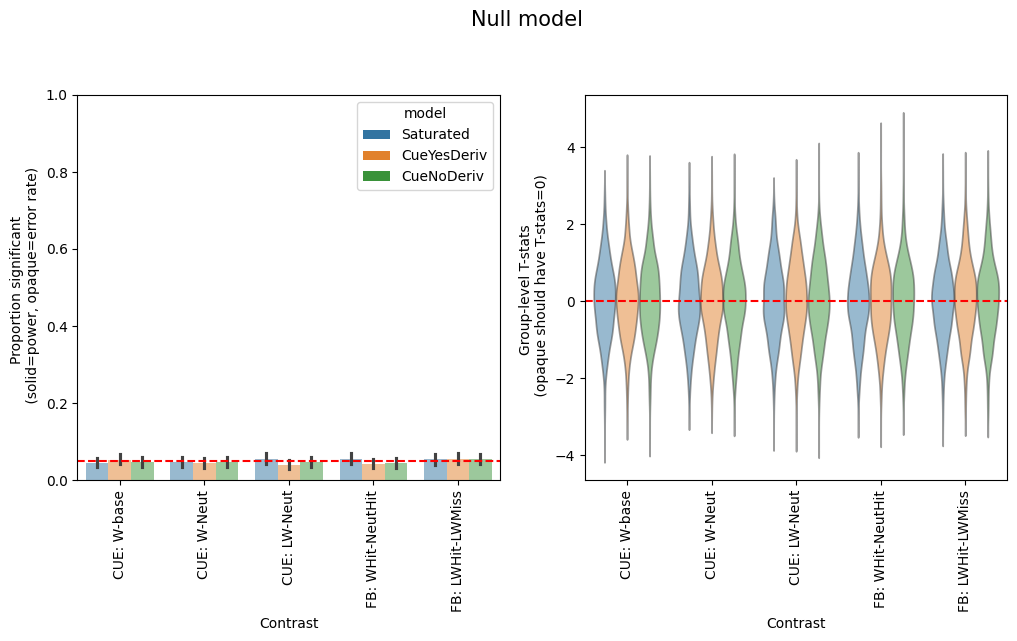

In [10]:
plot_dict_of_results({'Null model': results_jitter['Null model']}, contrasts=True)

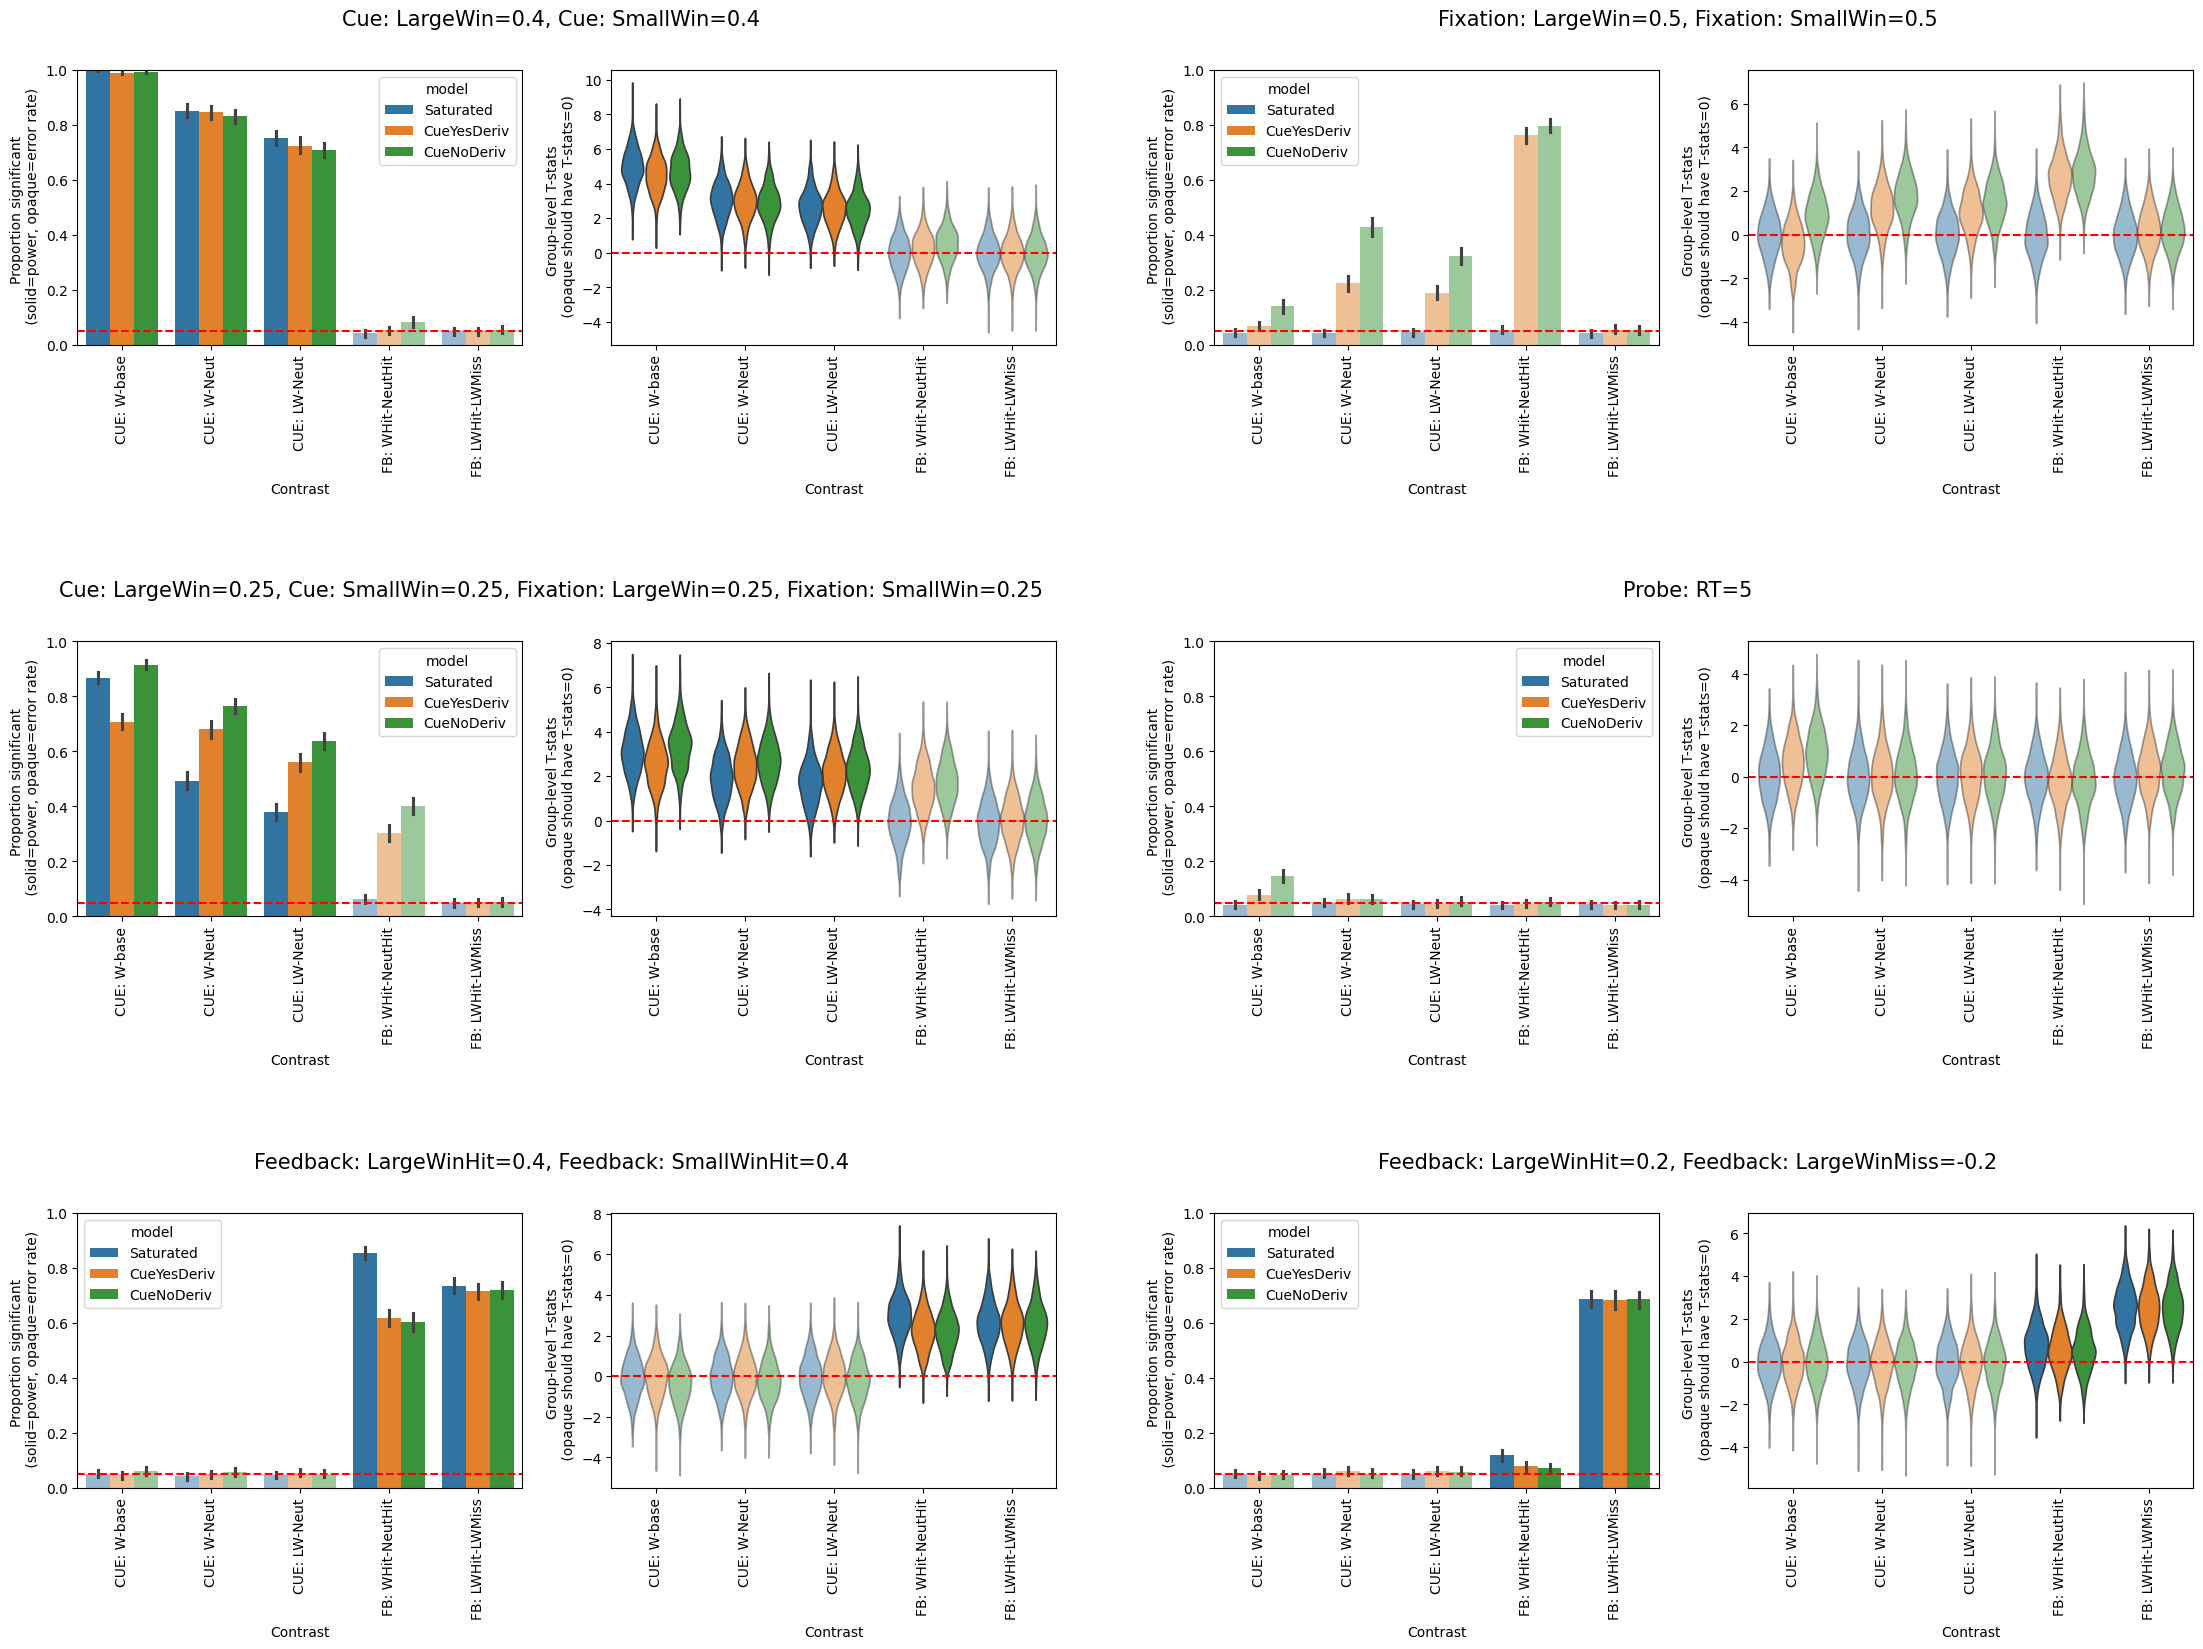

In [11]:
results_jitter_plot = results_jitter.copy()
results_jitter_plot.pop('Null model')
plot_dict_of_results(results_jitter_plot, contrasts=True)

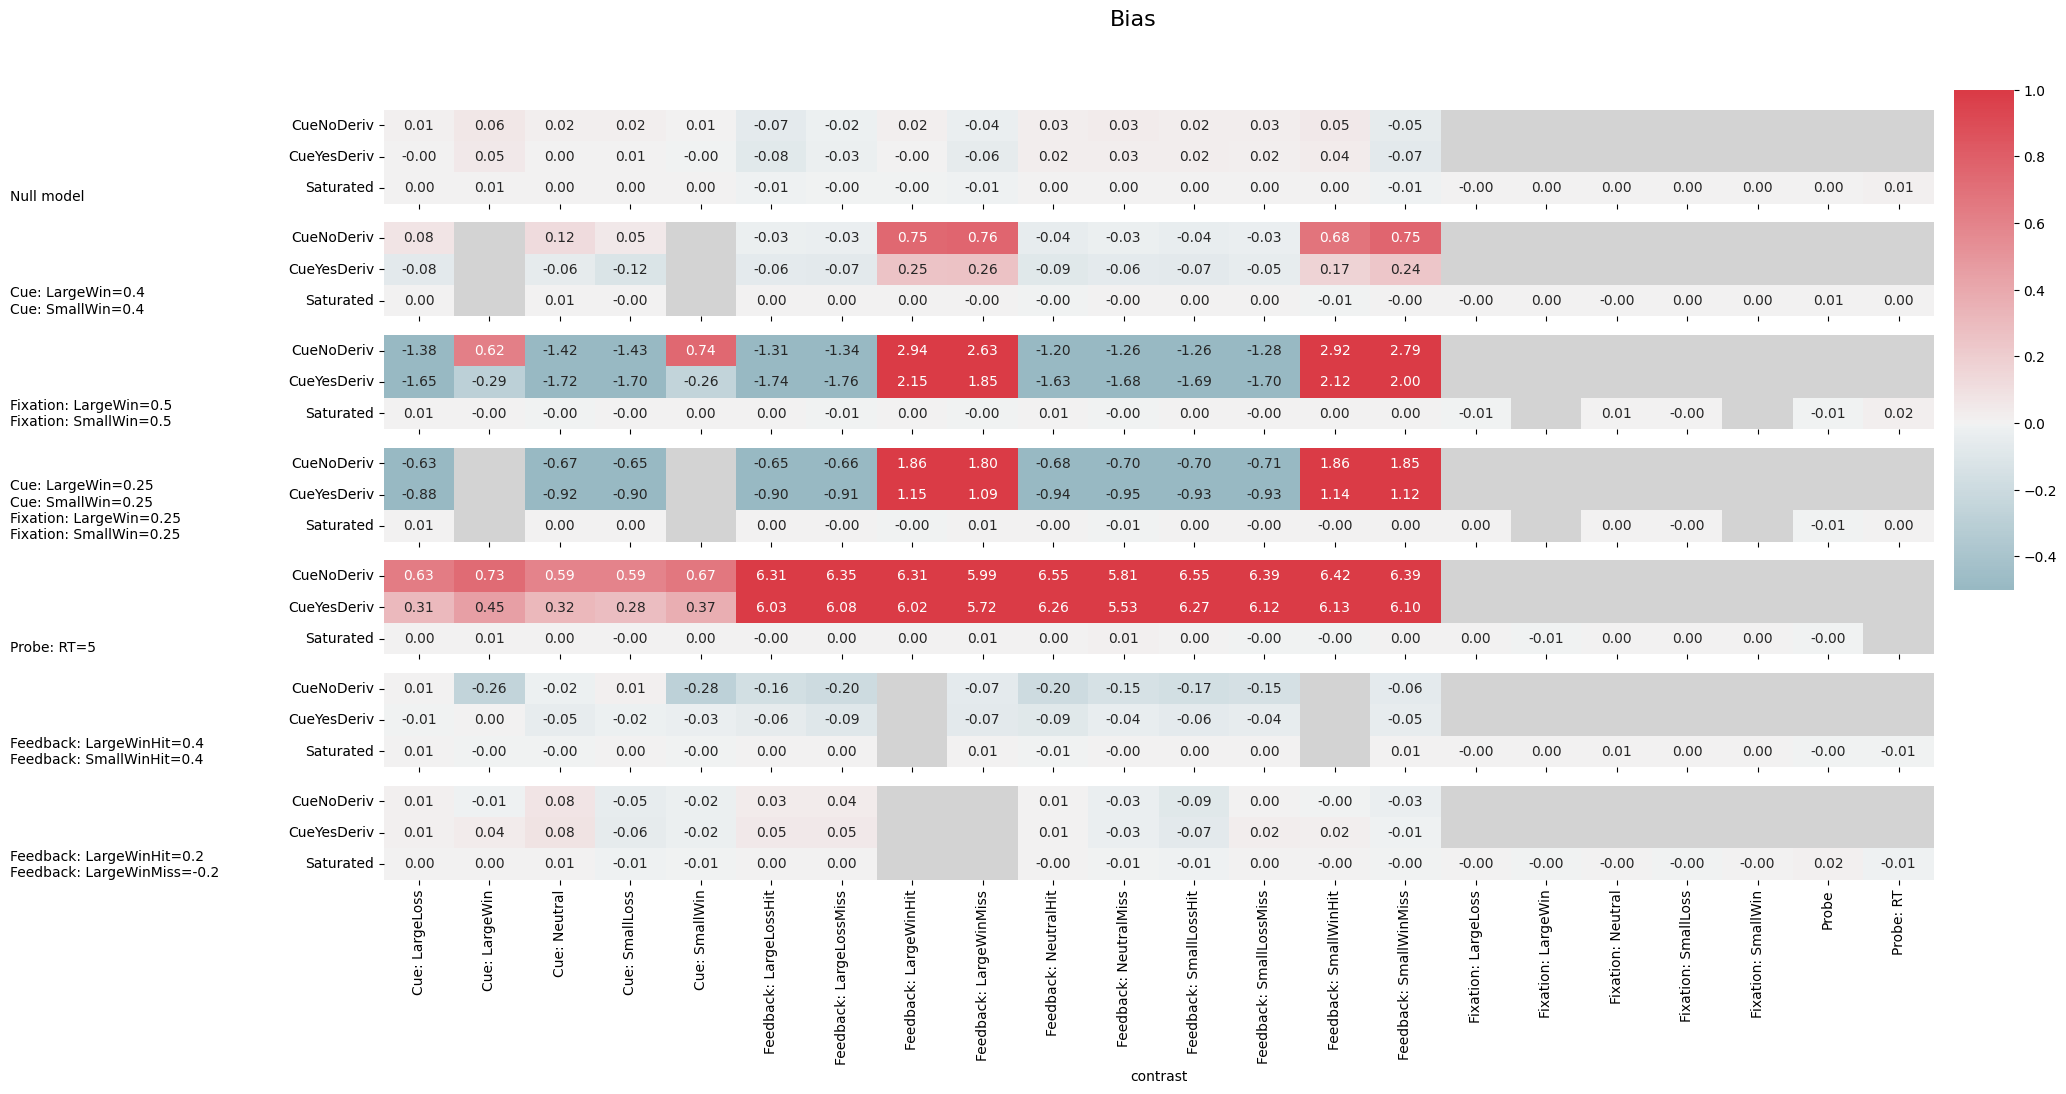

In [12]:
plot_bias(results_jitter)

# VIFs/efficiency

In [13]:
#oversampling=50, tr=.8, previously 5 and 1
vif_eff_no_jitter = est_eff_vif_all_subs(oversampling=50, tr=.8, dataset='ABCD')
vif_eff_yes_jitter = est_eff_vif_all_subs(oversampling=50, tr=.8, jitter=True, jitter_iti_min=2, jitter_iti_max=6, dataset='ABCD')

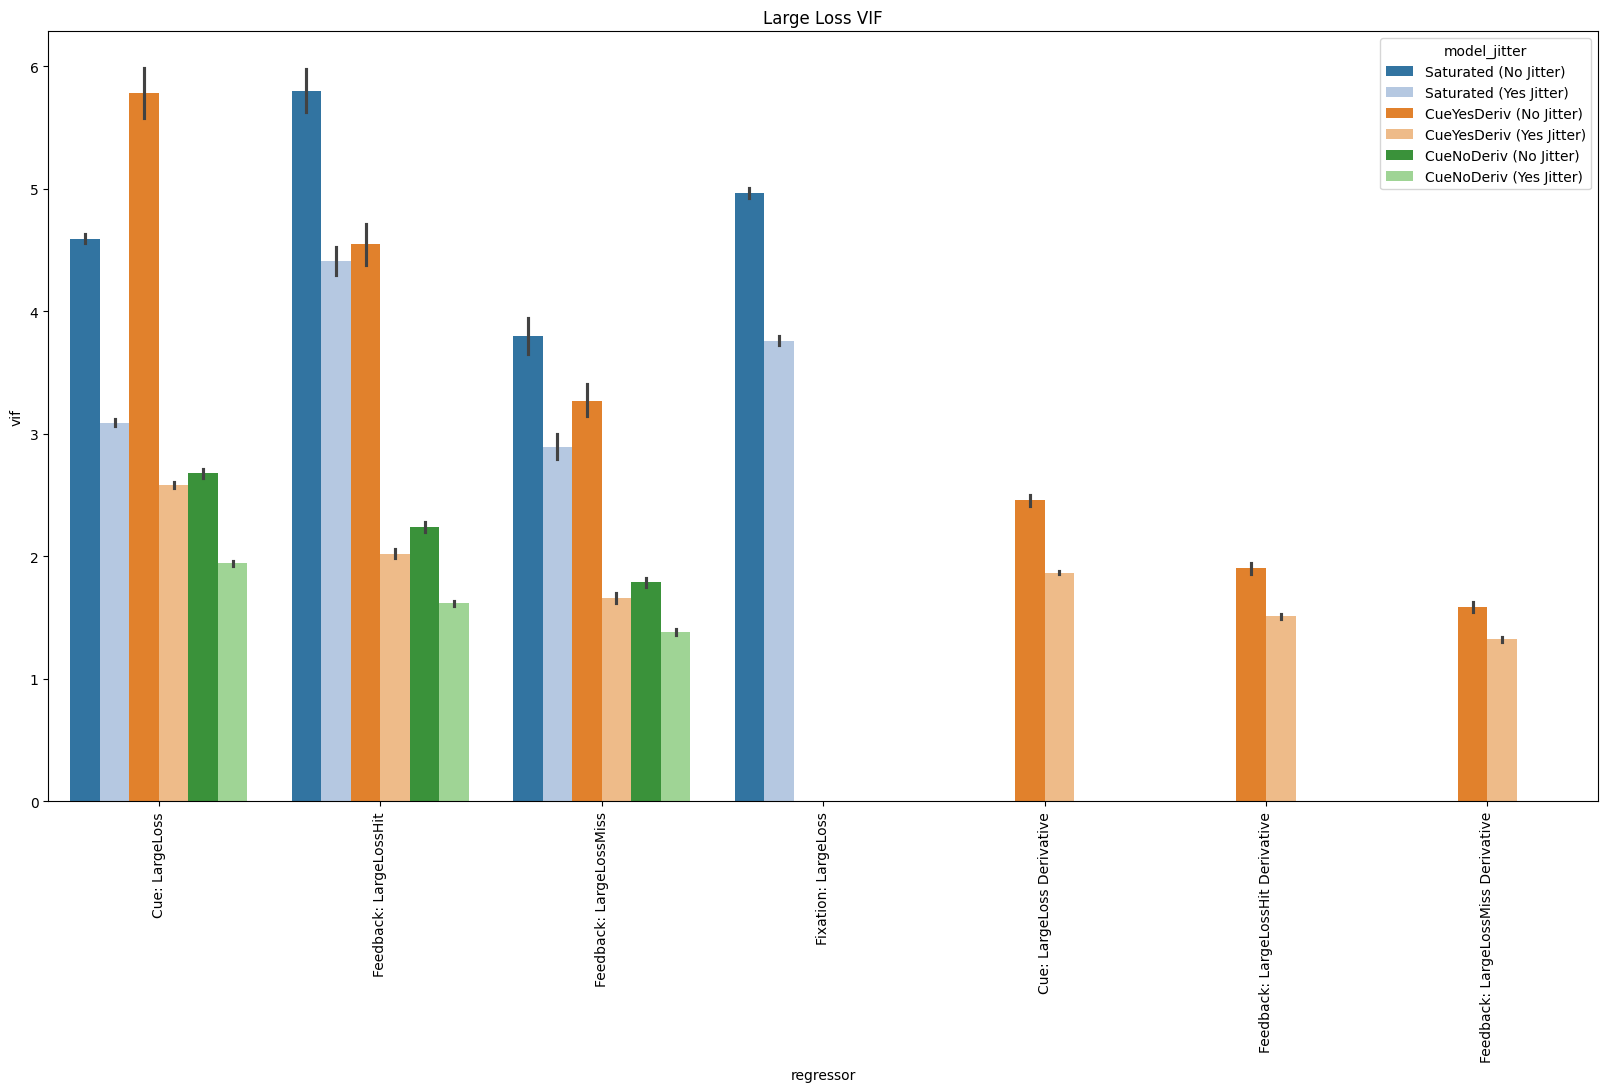

In [14]:
vif_eff_no_jitter['vifs']['Jitter'] = 'No Jitter'
vif_eff_yes_jitter['vifs']['Jitter'] = 'Yes Jitter'
vif_dat_plot = pd.concat([vif_eff_no_jitter['vifs'], vif_eff_yes_jitter['vifs']])

vif_dat_plot['model_jitter'] = vif_dat_plot['model'] + ' (' + vif_dat_plot['Jitter'] + ')'
# sufficient to just look at LargeLoss
vif_dat_large_loss = vif_dat_plot[vif_dat_plot['regressor'].str.contains('LargeLoss')]
fig = plt.subplots(1, 1, figsize=(20, 10))
hue_order = [f'{model} {jitter_type}' for model in ['Saturated', 'CueYesDeriv', 'CueNoDeriv'] for jitter_type in ['(No Jitter)', '(Yes Jitter)']]
sns.barplot(data=vif_dat_large_loss, x='regressor', y='vif', 
                   hue='model_jitter', hue_order=hue_order, palette='tab20')
plt.tick_params(axis='x', rotation=90)
plt.title('Large Loss VIF')
plt.show()

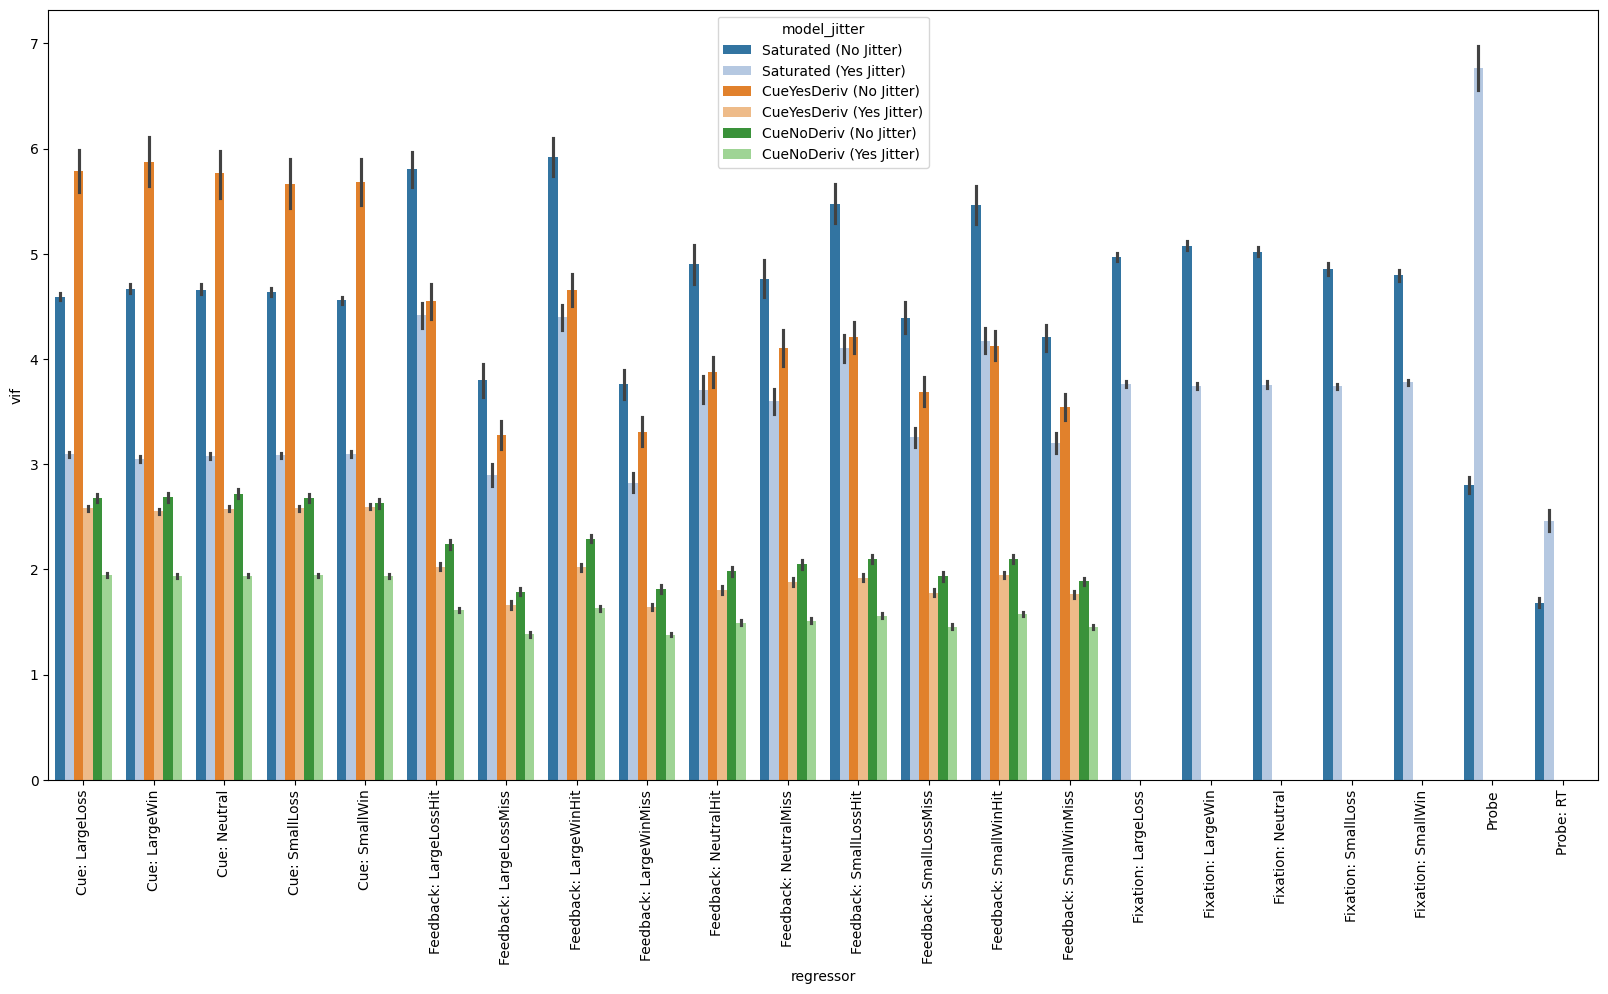

In [15]:
# Too messy with everything?
vif_dat_large_loss = vif_dat_plot[~vif_dat_plot['regressor'].str.contains('Derivative|constant')]
fig = plt.subplots(1, 1, figsize=(20, 10))
hue_order = [f'{model} {jitter_type}' for model in ['Saturated', 'CueYesDeriv', 'CueNoDeriv'] for jitter_type in ['(No Jitter)', '(Yes Jitter)']]
sns.barplot(data=vif_dat_large_loss, x='regressor', y='vif', 
                   hue='model_jitter', hue_order=hue_order, palette='tab20')
plt.tick_params(axis='x', rotation=90)
#plt.title('Large Loss VIF')
plt.show()

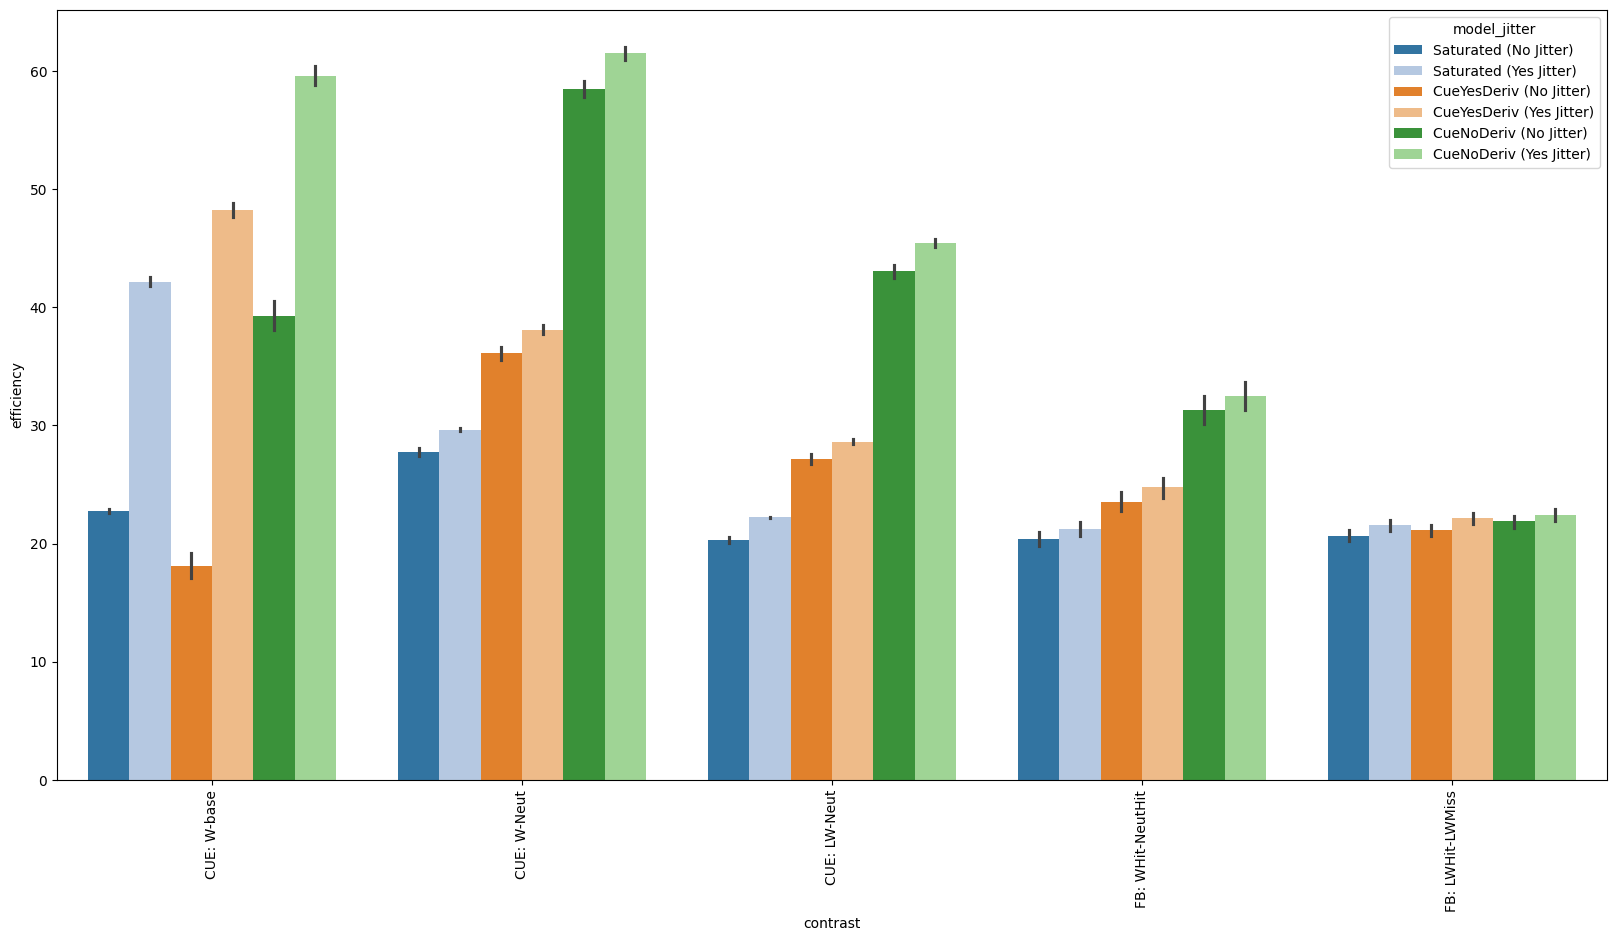

In [16]:
vif_eff_no_jitter['efficiencies']['Jitter'] = 'No Jitter'
vif_eff_yes_jitter['efficiencies']['Jitter'] = 'Yes Jitter'
eff_dat_plot = pd.concat([vif_eff_no_jitter['efficiencies'], vif_eff_yes_jitter['efficiencies']])
eff_dat_plot['model_jitter'] = eff_dat_plot['model'] + ' (' + eff_dat_plot['Jitter'] + ')'

eff_dat_no_cue_fix = eff_dat_plot
eff_dat_no_cue_fix_contrasts = eff_dat_no_cue_fix[eff_dat_no_cue_fix['contrast'].str.contains('-')]

hue_order = [f'{model} {jitter_type}' for model in ['Saturated', 'CueYesDeriv', 'CueNoDeriv'] for jitter_type in ['(No Jitter)', '(Yes Jitter)']]

fig = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(data=eff_dat_no_cue_fix_contrasts, x='contrast', y='efficiency', 
                   hue='model_jitter', hue_order=hue_order, palette='tab20')
#plt.ylim(0,.01)
plt.tick_params(axis='x', rotation=90)
plt.show()